# Projet 4 - Anticipez les besoins en consommation de bâtiments

# Plan du notebook

* [Introduction - Rappel de la problématique](#Introduction)
* [1. Chargement des fichiers et modules](#chapter1)
* [2. Préparation du jeu de données](#chapter2)
    * [2.1. Traduction des colonnes](#subchapter2.1)
    * [2.2. Description du jeu de données](#subchapter2.2)
    * [2.3. Simplification du jeu de données](#subchapter2.3)
    * [2.4. Transformation / Creation des variables](#subchapter2.4)
* [3. Analyse exploratoire](#chapter3)
    * [3.1. Analyse univariée](#subchapter3.1)
    * [3.2. Analyse bivariée](#subchapter3.2)
    * [3.3. Analyse exploratoire du texte](#subchapter3.3)
* [4. Première modélisation](#chapter4)
    * [4.1. Evaluation de la performance et Choix des *metrics*](#subchapter4.1)
    * [4.2. Application d'un modèle de régression multi-linéaire](#subchapter4.2)
    * [4.3. Application d'un modèle dummy_regressor](#subchapter4.3)
* [5. Feature engineering avancé](#chapter5)
    * [5.1. Analyse de l'asymétrie des variables numérique](#subchapter5.1)
    * [5.2. Travail sur la notion usage des bâtiments ](#subchapter5.2)
* [Annexes](#Annexes)
    * [Annexe 1 : Visualisation géographique des bâtiments](#Annexes1)

# Introduction - Rappel de la problématique <a class="anchor" id="Introduction"></a>

Le but de ce projet est de **prédire la consommation d'énergie, ainsi que les émissions de CO2, des bâtiments non résidentiels de l'agglomération de Seattle**. Le modèle prédictif devra être basé sur les caractéristiques géographiques, structurelles et fonctionnelles des bâtiments.

D'un point de vue *Data*, les enjeux du projets sont les suivants:
- Retraiter le jeu de données des variables à travers un *préprocessing* adapté
- Elaborer 2 modèles supervisés de régression, le premier pour la consommation énergétique, le second pour les émissions de CO2.
- Evaluer plusieurs typologies de modèles de régression et identifier le meilleur type de modèle.
- Explorer et optimiser les hyperparamètres du modèle retenu.

Après lecture des définitions du jeu de données, les 2 *targets* (=cibles) de nos modèles prédictifs sont : 
- La variable "**Conso_énergie_norm**" (=**SiteEnergyUseWN(kBtu)**), qui représente la consommation totale en énergie du site en fonction de sa surface. Cette valeur présente pour unité des kBtuf (*thousands of British thermal units*), elle a été normalisée en prennant en compte la météorologie des 30 dernières années ; on s'affranchira ainsi de tout évènement exceptionnel sur l'année 2016. 
- La variable "**Emissions_CO2**" (=**TotalGHGEmissions**), qui représente la quantité totale d'émissions de gaz à effet de serre , et notamment de CO2.

# 1. Chargement des fichiers et modules <a class="anchor" id="chapter1"></a>

In [1]:
#!pip install missingno

In [2]:
# Importation des modules génériques (hors sklearn)
import os
import sys
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno # Librairie de visualisation des valeurs manquantes
from IPython.display import Markdown as md # Librairie Markdown
from tabulate import tabulate # Librairie de visualisation des listes sous forme de tableau
import time # Fonction de de capture du temps (temps execution)
import warnings

In [3]:
# Paramétrage des limites d'affichage
pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# Versions utilisées
print('NumPy' + ((30 - len('NumPy'))*"_") + np.version.full_version)
print('Pandas' + ((30 - len('Pandas'))*"_") + pd.__version__)
print('Python' + ((30 - len('Python'))*"_") + sys.version)
print('Seaborn' + ((30 - len('Seaborn'))*"_") + sns.__version__)
print('Scikit-learn' + ((30 - len('Scikit-learn'))*"_") + sklearn.__version__)

NumPy_________________________1.23.5
Pandas________________________1.5.3
Python________________________3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Seaborn_______________________0.12.2
Scikit-learn__________________1.2.1


In [5]:
# Chargement du fichier 
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [6]:
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA 98101.00   
1              Paramount Hotel  724 Pine street  Seattle    WA 98101.00   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA 98101.00   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA 98101.00   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA 98121.00   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN     47.61   
1                    0659000220                    7     DOWNTOWN     47.61   
2                    0659000475                    7     DOWNTOWN     47.61   
3                    0659000640                    7     DOWNTOWN     47.61   
4                    0659000970                    7     DOWNTOWN     47.61   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0    -122.34       1927               1.00              12             88434   
1    -122.33       1996               1.00              11            103566   
2    -122.34       1969               1.00              41            956110   
3    -122.34       1926               1.00              10             61320   
4    -122.34       1980               1.00              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                   88434.00   
1                  Hotel                   83880.00   
2                  Hotel                  756493.00   
3                  Hotel                   61320.00   
4                  Hotel                  123445.00   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                         15064.00   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                         68009.00   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                         4622.00   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                            0.00   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN            60.00             81.70   
1                      NaN            61.00             94.80   
2                      NaN            43.00             96.00   
3                      NaN            56.00            110.80   
4                      NaN            75.00            114.80   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0               84.30              182.50                189.00   
1               97.90              176.10                179.40   
2

# 2. Préparation du jeu de données <a class="anchor" id="chapter2"></a>

## 2.1. Traduction <a class="anchor" id="subchapter2.1"></a>

Dans un souci de facilité, les intitulés de colonne ont été traduits de l'anglais vers le français.

In [7]:
print(df.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [8]:
# Creation d'un dictionnaire de traduction des intitulés de colonne
dict_colonnes = {
    "OSEBuildingID":"ID",
    "DataYear":"Date_construction",
    "BuildingType":"Type_batiment",
    "PrimaryPropertyType":"Usage",
    "PropertyName":"Nom_propriete",
    "Address":"Adresse",
    "City":"Ville",
    "State":"Etat",
    "ZipCode":"Code_postal",
    "TaxParcelIdentificationNumber":"Num_parcelle",
    "CouncilDistrictCode":"Code_district",
    "Neighborhood":"Quartier",
    "Latitude":"Latitude",
    "Longitude":"Longitude",
    "YearBuilt":"Annee_construction",
    "NumberofBuildings":"Nb_batiments",
    "NumberofFloors":"Nb_etages",
    "PropertyGFATotal":"Surface_totale",
    "PropertyGFAParking":"Surface_parking",
    "PropertyGFABuilding(s)":"Surface_batiment",
    "ListOfAllPropertyUseTypes":"Liste_usages",
    "LargestPropertyUseType":"Usage_premier",
    "LargestPropertyUseTypeGFA":"Surface_premiere",
    "SecondLargestPropertyUseType":"Usage_second",
    "SecondLargestPropertyUseTypeGFA":"Surface_second",
    "ThirdLargestPropertyUseType":"Usage_tiers",
    "ThirdLargestPropertyUseTypeGFA":"Surface_tiers",
    "YearsENERGYSTARCertified":"Energystar_annees",
    "ENERGYSTARScore":"Energystar_score",
    "SiteEUI(kBtu/sf)":"Conso",
    "SiteEUIWN(kBtu/sf)":"Conso_norm",
    "SourceEUI(kBtu/sf)":"Conso_sources",
    "SourceEUIWN(kBtu/sf)":"Conso_source_norm",
    "SteamUse(kBtu)":"Conso_vapeur_kBtu",
    "SiteEnergyUse(kBtu)":"Conso_energie",
    "SiteEnergyUseWN(kBtu)":"Conso_energie_norm",
    "Electricity(kWh)":"Conso_electrique",
    "Electricity(kBtu)":"Conso_electrique_kBtu",
    "NaturalGas(therms)":"Conso_gaz",
    "NaturalGas(kBtu)":"Conso_gaz_kBtu",
    "DefaultData":"Donnees_par_defaut",
    "Comments":"Commentaires",
    "ComplianceStatus":"Reglementaire",
    "Outlier":"Outlier",
    "TotalGHGEmissions":"Emissions_CO2",
    "GHGEmissionsIntensity":"Emissions_index",
}

In [9]:
# Remplacement des en-tetes de colonnes
df = df.rename(columns=dict_colonnes)

## 2.2. Description du jeu de données <a class="anchor" id="subchapter2.2"></a>

In [10]:
print('La taille du dataset initial est de {0} lignes et de {1} colonnes.'.format(df.shape[0], df.shape[1]))

La taille du dataset initial est de 3376 lignes et de 46 colonnes.


In [11]:
print('Le nombre de valeurs manquantes est de {0}, ce qui correspond à {1:.2f}% du dataset.'.format(df.isna().sum().sum(), 100*df.isna().sum().sum()/(df.shape[0]*df.shape[1])))

Le nombre de valeurs manquantes est de 19952, ce qui correspond à 12.85% du dataset.


Le dataset initial se compose des types de variables suivants : 

In [12]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

Text(0.5, 1.0, 'Visualisation graphique du dataset et des données manquantes')

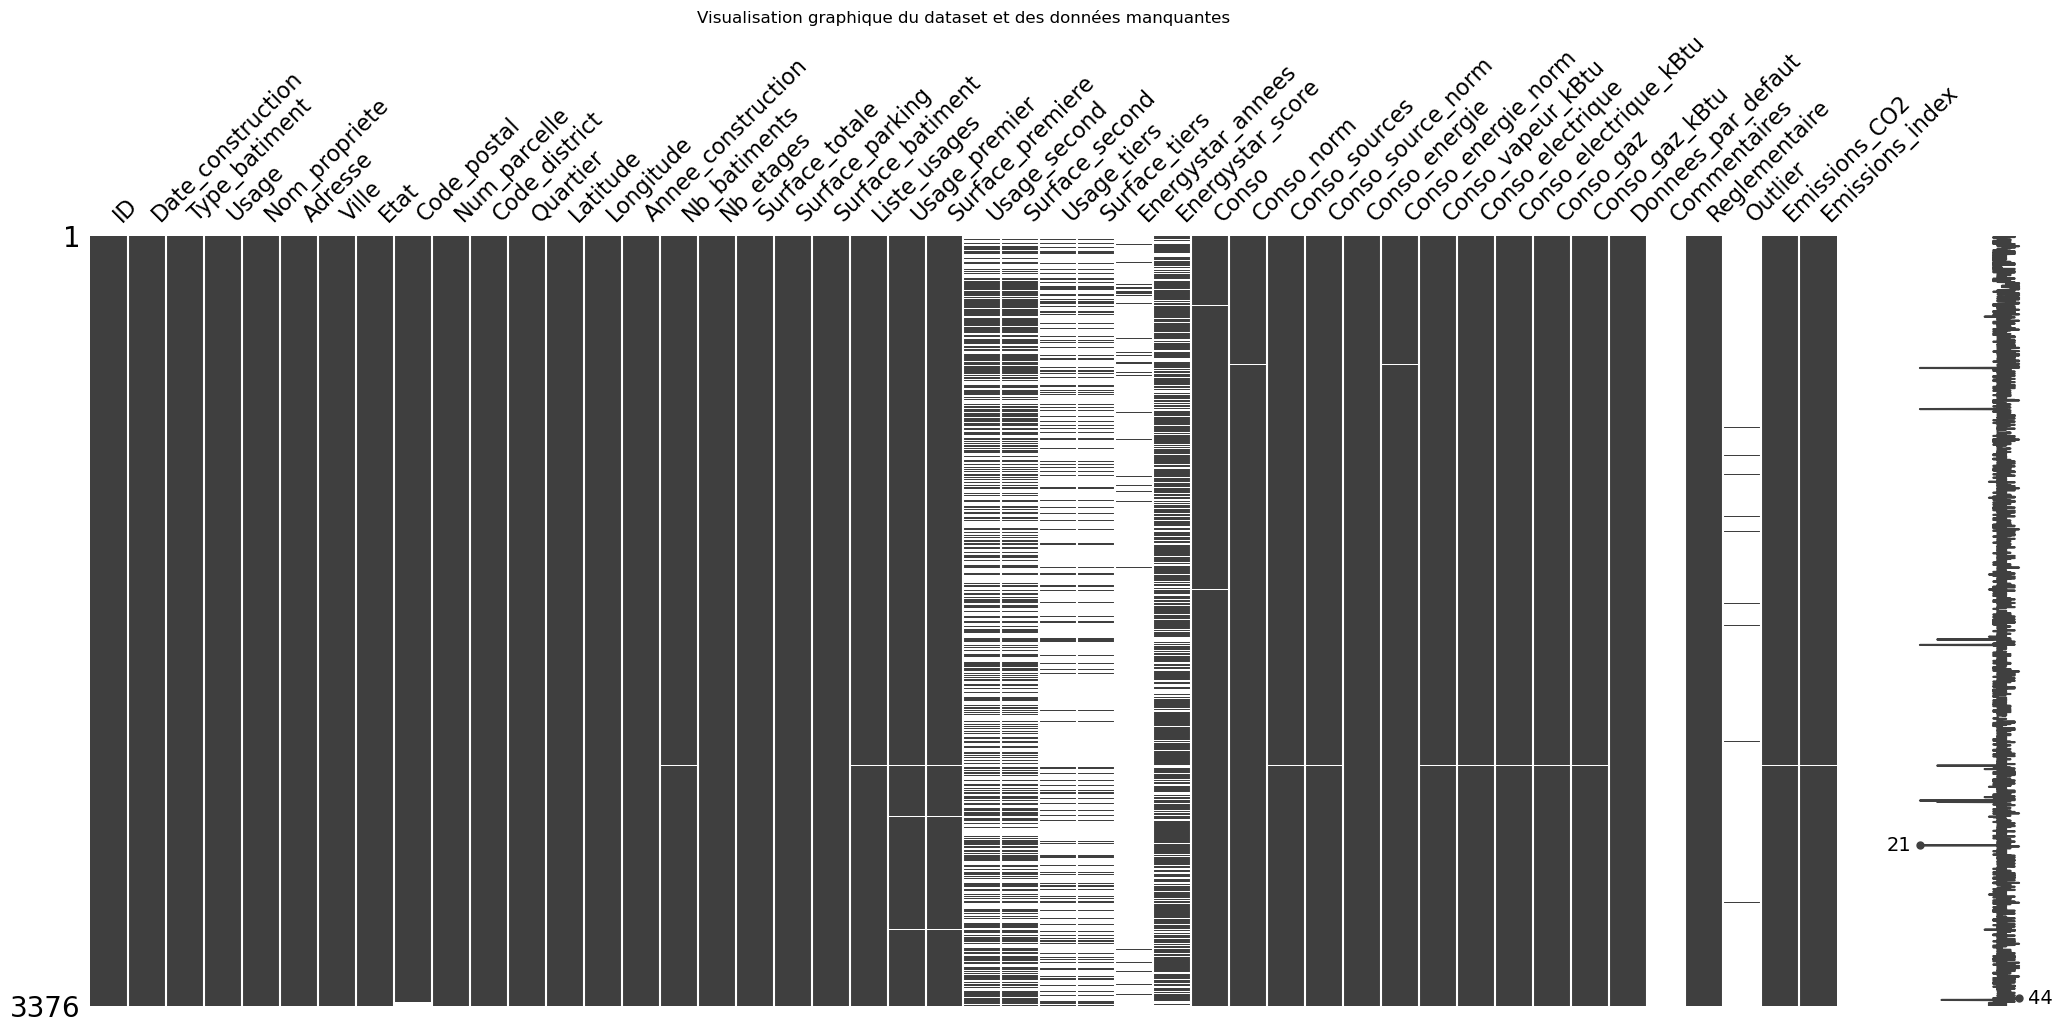

In [13]:
# Visualisation des données manquantes sous forme de heatmap
msno.matrix(df)
plt.title('Visualisation graphique du dataset et des données manquantes')

Ce sont essentiellement les colonnes liées aux usages secondaires et tertiaires qui présentent des valeurs manquantes, car certaines bâtiments ne possèdent qu'une seule et unique destination. 
Les colonnes "Energystar_annees", "Commentaires" et "Outlier" sont peu renseignées et pourront, à terme, être retirées.

In [36]:
print("L'energystar_score est enregistré pour {0:.1f}% des bâtiments.".format((1 - df['Energystar_score'].isna().mean())*100))

L'energystar_score est enregistré pour 75.0% des bâtiments.


In [37]:
Var_quantitatives = df.select_dtypes(include = ['int64', 'float64']).columns.to_list()
Var_qualitatives = df.select_dtypes(exclude = ['int64', 'float64']).columns.to_list()

In [38]:
# Passage en revue des variables qualitatives
print("Il y a", len(Var_qualitatives), "variables qualitatives.\n")
for col in df.select_dtypes("object"):
    if df[col].nunique() < 20:
        print (f'{col :-<50} {df[col].unique()}')
        print("__"*50)
    else :
        print(f'{col :-<50} contient {df[col].nunique()} valeurs différentes')

Il y a 16 variables qualitatives.

Type_batiment------------------------------------- ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
____________________________________________________________________________________________________
Usage--------------------------------------------- contient 24 valeurs différentes
Nom_propriete------------------------------------- contient 3362 valeurs différentes
Adresse------------------------------------------- contient 3354 valeurs différentes
Ville--------------------------------------------- ['Seattle']
____________________________________________________________________________________________________
Etat---------------------------------------------- ['WA']
____________________________________________________________________________________________________
Num_parcelle-------------------------------------- contient 3268 valeurs diff

In [39]:
print("Il y a", len(Var_quantitatives), "Variables quantitatives.\n")
num_rows = df.shape[0]

for col in df.select_dtypes(include=['float64', 'int64']):
    print(f'{col :-<50} contient {df[col].nunique()} valeurs différentes sur {num_rows} lignes')

Il y a 30 Variables quantitatives.

ID------------------------------------------------ contient 3376 valeurs différentes sur 3376 lignes
Date_construction--------------------------------- contient 1 valeurs différentes sur 3376 lignes
Code_postal--------------------------------------- contient 55 valeurs différentes sur 3376 lignes
Code_district------------------------------------- contient 7 valeurs différentes sur 3376 lignes
Latitude------------------------------------------ contient 2876 valeurs différentes sur 3376 lignes
Longitude----------------------------------------- contient 2656 valeurs différentes sur 3376 lignes
Annee_construction-------------------------------- contient 113 valeurs différentes sur 3376 lignes
Nb_batiments-------------------------------------- contient 17 valeurs différentes sur 3376 lignes
Nb_etages----------------------------------------- contient 50 valeurs différentes sur 3376 lignes
Surface_totale------------------------------------ contient 3195 val

In [40]:
print("La tableau ci-dessous présente des statistiques descriptives sur les variables numériques.\n")
df.describe().T

La tableau ci-dessous présente des statistiques descriptives sur les variables numériques.



count       mean         std        min       25%  \
ID                    3376.00   21208.99    12223.76       1.00  19990.75   
Date_construction     3376.00    2016.00        0.00    2016.00   2016.00   
Code_postal           3360.00   98116.95       18.62   98006.00  98105.00   
Code_district         3376.00       4.44        2.12       1.00      3.00   
Latitude              3376.00      47.62        0.05      47.50     47.60   
Longitude             3376.00    -122.33        0.03    -122.41   -122.35   
Annee_construction    3376.00    1968.57       33.09    1900.00   1948.00   
Nb_batiments          3368.00       1.11        2.11       0.00      1.00   
Nb_etages             3376.00       4.71        5.49       0.00      2.00   
Surface_totale        3376.00   94833.54   218837.61   11285.00  28487.00   
Surface_parking       3376.00    8001.53    32326.72       0.00      0.00   
Surface_batiment      3376.00   86832.01   207939.81    3636.00  27756.00   
Surface_premiere      3356.00   79177.64   201703.41    5656.00  25094.75   
Surface_second        1679.00   28444.08    54392.92       0.00   5000.00   
Surface_tiers          596.00   11738.68    29331.20       0.00   2239.00   
Energystar_score      2533.00      67.92       26.87       1.00     53.00   
Conso                 3369.00      54.73       56.27       0.00     27.90   
Conso_norm            3370.00      57.03       57.16       0.00     29.40   
Conso_sources         3367.00     134.23      139.29       0.00     74.70   
Conso_source_norm     3367.00     137.78      139.11      -2.10     78.40   
Conso_energie         3371.00 5403667.29 21610628.63       0.00 925128.59   
Conso_energie_norm    3370.00 5276725.71 15938786.48       0.00 970182.23   
Conso_vapeur_kBtu     3367.00  274595.90  3912173.39       0.00      0.00   
Conso_electrique      3367.00 1086638.97  4352478.36  -33826.80 187422.95   
Conso_electrique_kBtu 3367.00 3707612.16 14850656.14 -115417.00 639487.00   
Conso_gaz             3367.00   13685.05    67097.81       0.00      0.00   
Conso_gaz_kBtu        3367.00 1368504.54  6709780.83       0.00      0.00   
Commentaires             0.00        NaN         NaN        NaN       NaN   
Emissions_CO2         3367.00     119.72      538.83      -0.80      9.50   
Emissions_index       3367.00       1.18        1.82      -0.02      0.21   

                             50%        75%          max  
ID                      23112.00   25994.25     50226.00  
Date_construction        2016.00    2016.00      2016.00  
Code_postal             98115.00   98122.00     98272.00  
Code_district               4.00       7.00         7.00  
Latitude                   47.62      47.66        47.73  
Longitude                -122.33    -122.32      -122.22  
Annee_construction       1975.00    1997.00      2015.00  
Nb_batiments                1.00       1.00       111.00  
Nb_etages                   4.00       5.00        99.00  
Surface_totale          44175.00   90992.00   9320156.00  
Surface_parking             0.00       0.00    512608.00  
Surface_batiment        43216.00   84276.25   9320156.00  
Surface_premiere        39894.00   76200.25   9320156.00  
Surface_second          10664.00   26640.00    686750.00  
Surface_tiers            5043.00   10138.75    459748.00  
Energystar_score           75.00      90.00       100.00  
Conso                      38.60      60.40       834.40  
Conso_norm                 40.90      64.28       834.40  
Conso_sources              96.20     143.90      2620.00  
Conso_source_norm         101.10     148.35      2620.00  
Conso_energie         1803753.25 4222455.25 873923712.00  
Conso_energie_norm    1904452.00 4381429.12 471613856.00  
Conso_vapeur_kBtu           0.00       0.00 134943456.00  
Conso_electrique       345129.91  829317.84 192577488.00  
Conso_electrique_kBtu 1177583.00 2829632.50 657074389.00  
Conso_gaz                3237.54   11890.33   2979090.00  
Conso_gaz_kBtu         323754.00 1189033.50

 On constate que certaines variables prennent en dehors de toute logique la valeur "0". C'est le cas de :
- *Nb_batiments*
- *Nb_etages*
- *Conso_energie_norm* 

La variable <b>"Emissions_CO2"</b> prend par ailleurs des valeurs négatives, ce qui est incohérent avec sa définition.
Ces variables seront corrigées lors de l'imputation en [chapitre 2.4](#subchapter2.4).

## 2.3. Simplification du jeu de données <a class="anchor" id="subchapter2.3"></a>

#### Réduction du nombre de lignes

Le choix est fait d'éliminer les propriétés qui présentent un statut réglementaire "*Non-compliant*" ou "*Error - Correct Default Data*", car elles sont par définition non-comparables aux autres propriétés. Une mise en conformité du benchmarking sera exigée avant de les intégrer au modèle afin de maîtriser la **qualité des données**.

In [41]:
# Filtre sur les proprités compliantes
print(df['Reglementaire'].value_counts())
df = df[df['Reglementaire']=='Compliant']

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: Reglementaire, dtype: int64


L'énoncé de notre problème précise bien que seules les propriétés non résidentielles doivent être analysées. Par conséquent, tous les types de bâtiment contenant la mention *family* ou *multi-family* seront retirés de l'étude.

### on supprime toutes les samples representant les batiments habitables

In [42]:
df['Type_batiment'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'Campus', 'SPS-District K-12', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [43]:
# Filtre sur les données non résidentielles
df = df[df['Type_batiment'].str.contains('family') == False]

In [44]:
# Retrait des valeurs négatives de "Emissions_CO2"
df = df[df['Emissions_CO2']>=0]

#### Réduction du nombre de colonnes

In [45]:
# Suppression des variables inutiles
colonnes_inutiles = ['Ville', 'Etat', 'Commentaires', 'Outlier', 'Energystar_annees', 'Reglementaire', 'Donnees_par_defaut']
df = df.drop(colonnes_inutiles, axis=1)

## 2.4. Transformation / Creation des variables <a class="anchor" id="subchapter2.4"></a>

### Harmonisation du contenu de la variable "Quartiers"

Plusieurs doublons de saisie (sensibilité à la casse) existent pour la variable "Quartiers". Les différents "Quartiers" sont donc harmonisés.

In [46]:
df['Quartier'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [47]:
# Passage en lettre majuscule des quartiers
df['Quartier'] = df['Quartier'].str.upper()
df['Quartier'] = df['Quartier'].replace(to_replace='DELRIDGE NEIGHBORHOODS', value='DELRIDGE') # prendre tous les voisins de DELI... comme DE...

In [48]:
df['Quartier'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH'], dtype=object)

In [49]:
df.loc[df.index==353, :]

ID  Date_construction   Type_batiment                  Usage  \
353  496               2016  NonResidential  Self-Storage Facility   

        Nom_propriete                Adresse  Code_postal Num_parcelle  \
353  Market St Center  2811 NW Market Street     98107.00   1175001235   

     Code_district Quartier  Latitude  Longitude  Annee_construction  \
353              6  BALLARD     47.67    -122.39                1946   

     Nb_batiments  Nb_etages  Surface_totale  Surface_parking  \
353          2.00          2          111445                0   

     Surface_batiment                                       Liste_usages  \
353            111445  Fitness Center/Health Club/Gym, Office, Other ...   

    Usage_premier  Surface_premiere Usage_second  Surface_second Usage_tiers  \
353           NaN               NaN          NaN             NaN         NaN   

     Surface_tiers  Energystar_score  Conso  Conso_norm  Conso_sources  \
353            NaN               NaN  47.80       51.00         103.00   

     Conso_source_norm  Conso_energie  Conso_energie_norm  Conso_vapeur_kBtu  \
353             106.40     5697472.50          6076957.00               0.00   

     Conso_electrique  Conso_electrique_kBtu  Conso_gaz  Conso_gaz_kBtu  \
353         881452.00             3007514.00   26899.58      2689958.00   

     Emissions_CO2  Emissions_index  
353         163.83             1.47

In [51]:
import seaborn as sb

In [140]:
df_copie = df.copy()

In [141]:
df_copie.Usage_premier.isna().sum()

4

In [142]:
indexs = df_copie[df_copie.Usage_premier.isna()].index.to_list()
print(index)

[353, 1147, 2414, 2459]


In [143]:
for index in indexs:
    df_copie.loc[df_copie.index==index, 'Usage_premier'] = df_copie.loc[df_copie.index==index, 'Usage'] 

In [144]:
df_copie[df_copie.Usage_premier.isna()]["Usage_premier"]

Series([], Name: Usage_premier, dtype: object)

### Ajout des usages manquants et  corrections des outliers

In [26]:
# Saisie de l'usage primaire pour les propriétés pour lesquelles cette information est absente. 
df.loc[df.index==353, 'Usage_premier'] = "Self-Storage Facility"
df.loc[df.index==1147, 'Usage_premier'] = "Hotel"
df.loc[df.index==2414, 'Usage_premier'] = "Office"
df.loc[df.index==2459, 'Usage_premier'] = "Restaurant"

# On suppose que Surface usage primaire = surface totale car il n'existe qu'un seul usage
df.loc[df.index==353, 'Surface_premiere'] = df.loc[df.index==353, 'Surface_totale']
df.loc[df.index==1147, 'Surface_premiere'] = df.loc[df.index==1147, 'Surface_totale']
df.loc[df.index==2414, 'Surface_premiere'] = df.loc[df.index==1147, 'Surface_totale']
df.loc[df.index==2459, 'Surface_premiere'] = df.loc[df.index==1147, 'Surface_totale']

In [37]:
# Correction du batiment présentant 99 étages, qui se trouve être une église.
#df[df['Nb_etages']==99]
df.loc[df.index==1359, 'Nb_etages'] = 2

### Imputation des valeurs manquantes

Les variables *Conso_energie* et *Conso_energie_norm* étant fortement correlées l'une à l'autre (r=0,99), les valeurs à "0" de *Conso_energie_norm* seront imputées à l'aide d'un IterativeImputer. 

In [38]:
# Importation des fonctions d'imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

In [39]:
def application_iterativeimputer(df, variables):
    df_imputed = df[variables]
    imp_median = IterativeImputer(random_state=21, missing_values=np.nan)
    imp_median.fit(df_imputed)
    df_imputed = imp_median.transform(df_imputed)
    return df_imputed

In [41]:
df.loc[df['Conso_energie_norm']==0, 'Conso_energie_norm'] = np.nan
X = application_iterativeimputer(df, ['Conso_energie', 'Conso_energie_norm'])
df['Conso_energie_norm'] = np.round(X[:,1],2)

Il existe quelques valeurs nulles sur les variables *Nb_etages* et *Nb_batiment* ce qui est physiquement impossible. Ces valeurs manquantes vont être remplacées dans la logique d'un *SimpleImputer* par la valeur médiane de la variable.

In [40]:
# Remplacement des valeurs nulles par des np.nan
df.loc[df['Nb_etages']==0, 'Nb_etages'] = np.nan
df.loc[df['Nb_batiments']==0, 'Nb_batiments'] = np.nan
# Imputation par la valeur mediane
df['Nb_etages'] = df['Nb_etages'].fillna(df['Nb_etages'].median())
df['Nb_batiments'] = df['Nb_batiments'].fillna(df['Nb_batiments'].median())

### Création de nouvelles *features*

In [42]:
nouvelles_variables = ['Pourcent_parking', 'Pourcent_elec', 'Pourcent_vapeur', 'Pourcent_gaz', 'Nb_usages', 'Surface_etage', 'Surface_batiment']
nouvelles_unites = ['%', '%', '%', '%', '#', 'pied²/etage', 'pied²/batiment']
nouvelles_definitions = ['Pourcentage de surface occupée par des parkings.', 'Pourcentage d\'électricité parmis les sources d\'énergie.', 
                        'Pourcentage de vapeur parmis les sources d\'énergie.', 'Pourcentage de gaz parmis les sources d\'énergie.',
                        'Nombre de cas d\'usages des bâtiments', 'Surface moyenne par étage', 'Surface moyenne par batiment']
data = {'Variables': nouvelles_variables,
        'Unités': nouvelles_unites,
        'Definitions': nouvelles_definitions}

Un certain nombre de variables peuvent être recoupées entre-elles, sous forme de ratio, pour en créer de nouvelles. Le tableau suivant présente les variables nouvellement créees ainsi que leur définition.

In [43]:
df_nouvelles_variables = pd.DataFrame(data)
df_nouvelles_variables.style.set_properties(subset=['Definitions'], **{'width': '800px'})

In [44]:
# Fonction de recherche du nombre d'usages total 
def nombre_usages(texte):
    texte = str(texte)
    liste = texte.split(",")
    return len(liste)

In [45]:
# Fonction faisant apparaître la liste des usages pour chaque bâtiment
def usages(texte):
    texte = str(texte)
    liste = texte.split(",")
    return liste

In [46]:
# Creation des variables liées à l'énergie
df['Pourcent_parking'] = df['Surface_parking']  / df['Surface_totale'] 
df['Pourcent_elec'] = df['Conso_electrique_kBtu']  / df['Conso_energie']
df['Pourcent_vapeur'] = df['Conso_vapeur_kBtu']  / df['Conso_energie'] 
df['Pourcent_gaz'] = df['Conso_gaz_kBtu']  / df['Conso_energie']
df['Nb_usages'] = df['Liste_usages'].apply(nombre_usages)
df['Usages'] = df['Liste_usages'].apply(usages)
df['Surface_etage'] = df['Surface_totale']  / df['Nb_etages'] 
df['Surface_batiment'] = df['Surface_totale']  / df['Nb_batiments']

Une nouvelle variable catégorielle est aussi créée concernant l'année de construction. En effet, il existe 113 valeurs d'années différentes dans le dataset, cette variable étant numérique, elle risque d'induire un biais dans le modèle. Sur la base de l'histogramme affiché dans le chapitre [3.2.](#subchapter3.2), 3 catégries ont été créées : 
- Les bâtiments construits entre 1900 et 1945
- Les bâtiments construits entre 1945 et 1990
- Les bâtiments construits après 1990

In [47]:
# Classification de l'année de construction
df['Annee_cat'] = df['Annee_construction'].map(lambda x: 1 if x >= 1900 and x <= 1945
                            else (2 if x > 1935 and x <= 1990
                                 else 3))

# 3. Analyse exploratoire <a class="anchor" id="chapter3"></a>

## 3.1. Exploration univariée <a class="anchor" id="subchapter3.1"></a>

### Variables catégorielles

In [48]:
df['Quartier'].value_counts()

DOWNTOWN                 351
GREATER DUWAMISH         328
MAGNOLIA / QUEEN ANNE    144
LAKE UNION               143
NORTHEAST                117
EAST                     116
NORTHWEST                 78
BALLARD                   63
NORTH                     59
CENTRAL                   45
DELRIDGE                  41
SOUTHWEST                 31
SOUTHEAST                 31
Name: Quartier, dtype: int64

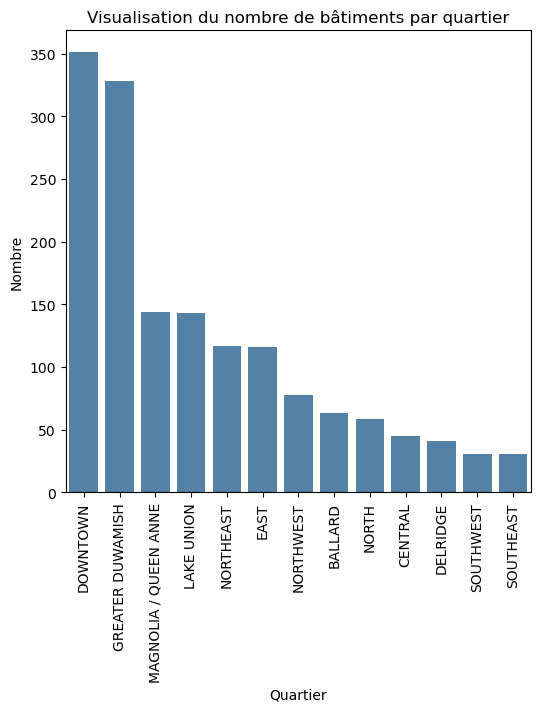

In [51]:
# Barplot par quartiers
plt.figure(figsize=(6,6))
order = df['Quartier'].value_counts().index
sns.countplot(data=df, x='Quartier', order = order, color='steelblue')
plt.title('Visualisation du nombre de bâtiments par quartier')
plt.xlabel('Quartier')
plt.xticks(rotation = 90)
plt.ylabel('Nombre')
plt.show()

Les 2 quartiers les plus représentés sont le centre-ville (=*Downtown*) et le *Greater Duwamish*. 
Les données du dataset sont relativement déséquilibrées en faveur de ces 2 quartiers.

In [52]:
df['Type_batiment'].value_counts()

NonResidential        1431
Nonresidential COS      81
Campus                  24
SPS-District K-12       10
Nonresidential WA        1
Name: Type_batiment, dtype: int64

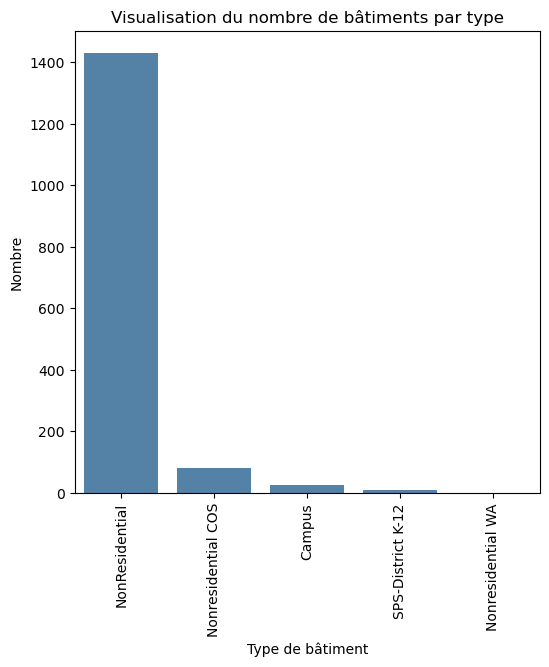

In [53]:
# Barplot par type de batiment
plt.figure(figsize=(6,6))
order = df['Type_batiment'].value_counts().index
sns.countplot(data=df, x='Type_batiment', order = order, color='steelblue')
plt.title('Visualisation du nombre de bâtiments par type')
plt.xlabel('Type de bâtiment')
plt.xticks(rotation = 90)
plt.ylabel('Nombre')
plt.show()

Le type de bâtiment le plus représenté correspond à *Non résidentiel*. Le *dataset* est fortement déséqsuilibré en faveur de ce type de bâtiment, ec qui risque de rendre la variable peu discriminante.

### Variables numériques

In [54]:
variables_num = ['Annee_construction', 'Nb_batiments', 'Nb_etages', 'Surface_totale', 
                 'Surface_parking', 'Surface_batiment', 'Surface_premiere', 'Nb_usages', 'Conso_vapeur_kBtu', 
                 'Conso_electrique_kBtu', 'Conso_gaz_kBtu', 'Conso_energie_norm', 'Emissions_CO2']

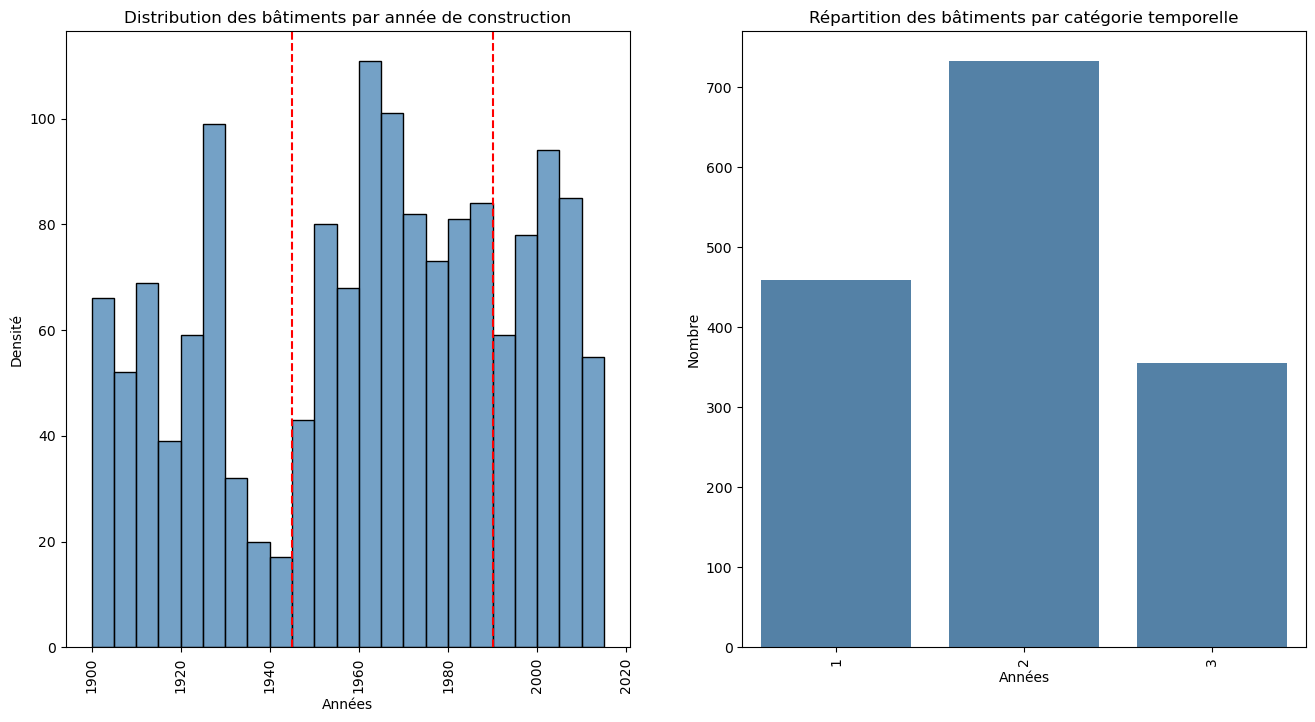

In [55]:
# Histogramme des années de construction
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.histplot(data=df, x='Annee_construction', color='steelblue', binwidth=5)
plt.title('Distribution des bâtiments par année de construction')
plt.xlabel('Années')
plt.xticks(rotation = 90)
plt.ylabel('Densité')
plt.axvline(1945, 0, 1, color='r', linestyle='--')
plt.axvline(1990, 0, 1, color='r', linestyle='--')

plt.subplot(1,2,2)
sns.countplot(data=df, x='Annee_cat', color='steelblue')
plt.title('Répartition des bâtiments par catégorie temporelle')
plt.xlabel('Années')
plt.xticks(rotation = 90) # xlabels=['1900-1945','1945-1990','ap.1990'],
plt.ylabel('Nombre')
plt.show()

Il existe beaucoup d'années de constructions différentes (113 en tout). Une tentative est faite afin de les carétgoriser en 3 groupes définis sur la base de l'histogramme. Nous verrons quelle variable fournit les meilleurs résultts dans l'exercice de modélisation. 

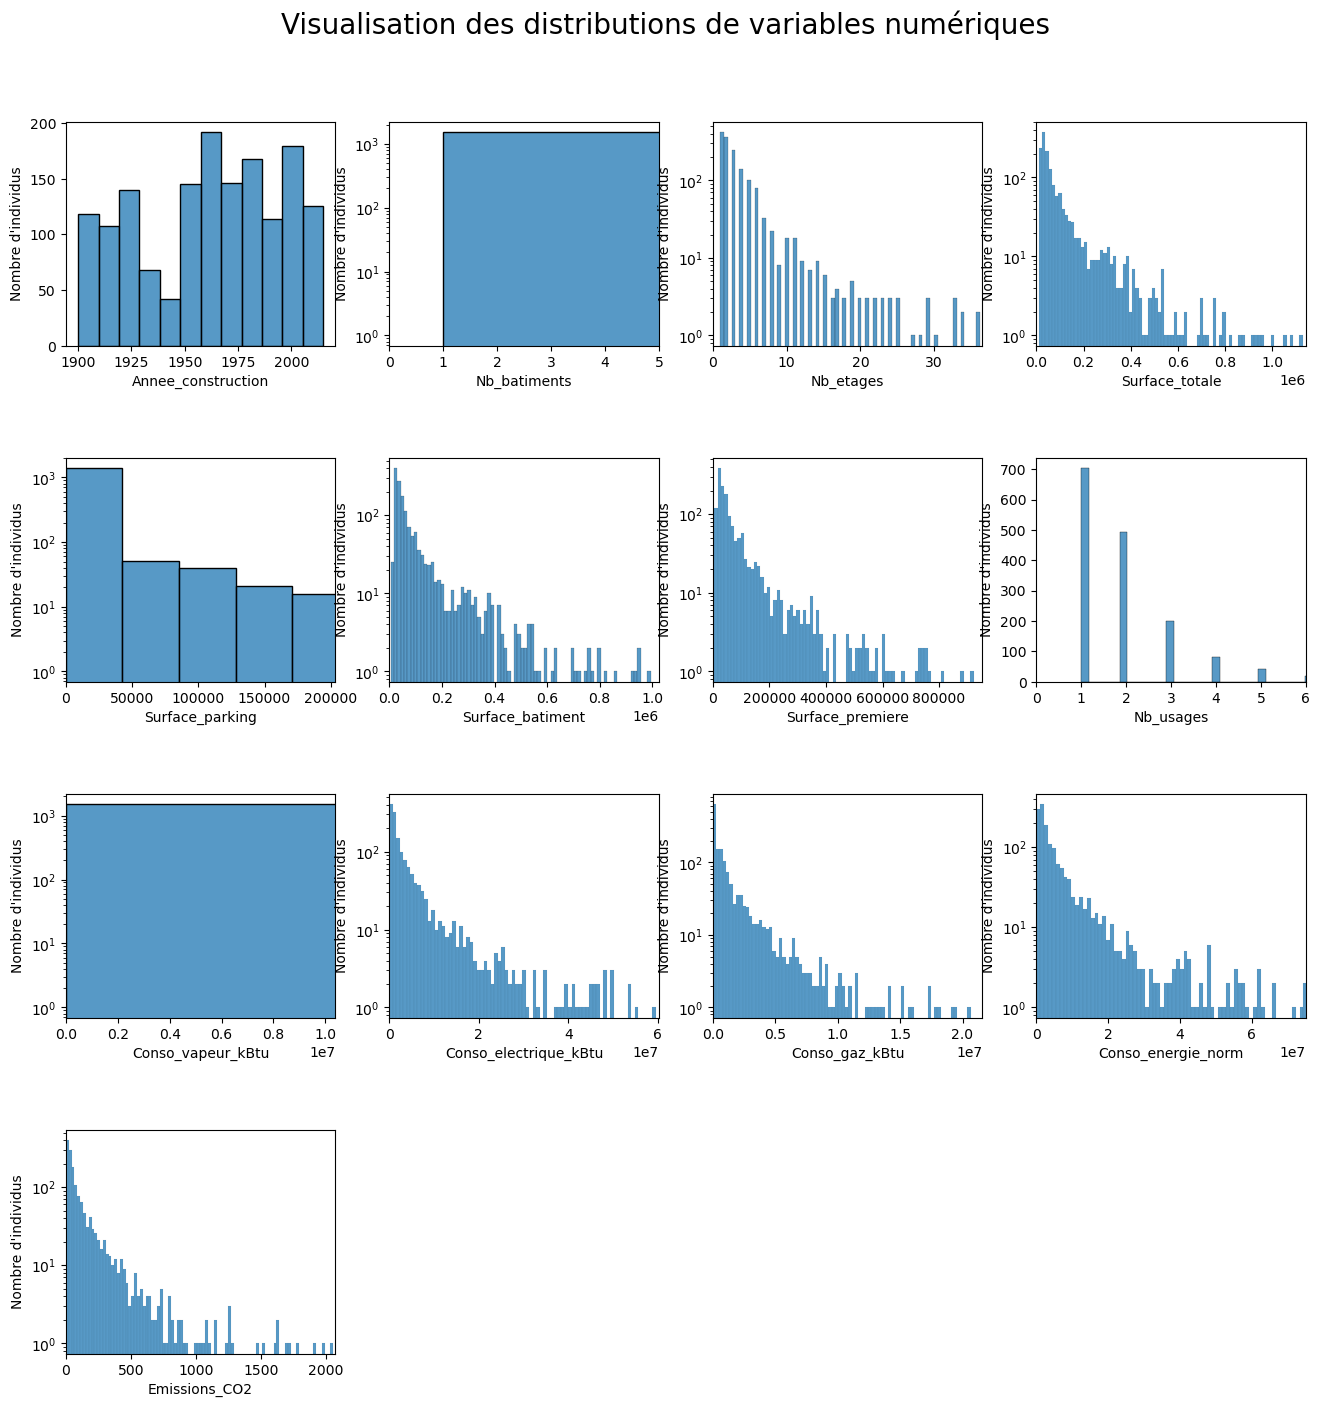

In [56]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Visualisation des distributions de variables numériques", fontsize=20, y=0.95)
variables_log = ['Nb_batiments', 'Nb_etages', 'Surface_totale', 
                 'Surface_parking', 'Surface_batiment', 'Surface_premiere', 'Conso_vapeur_kBtu', 
                 'Conso_electrique_kBtu', 'Conso_gaz_kBtu', 'Conso_energie_norm', 'Emissions_CO2']

for n, ticker in enumerate(variables_num):
    ax = plt.subplot(4, 4, n + 1)
    ax = sns.histplot(data=df, x=ticker)

    ax.set_ylabel("Nombre d'individus")
    if ticker in variables_log:
        ax.set_yscale('log')
    
    if ticker != "Annee_construction":
        xmax = df[ticker].astype(float).quantile(0.99) # Recherche du percentile 99% pour éviter l'affichage des valeurs extrêmes.
        plt.setp(ax, xlim=(0,xmax))

On constate que la plupart des variables présentent une distribution assez fortement asymétrique. Le calcul des scores de skewness et de kurtosis sera intéressant pour la suite de l'analyse, afin de transformer les variables si nécessaire.

## 3.2. Exploration bivariée <a class="anchor" id="subchapter3.2"></a>

### Variables catégorielles VS numériques

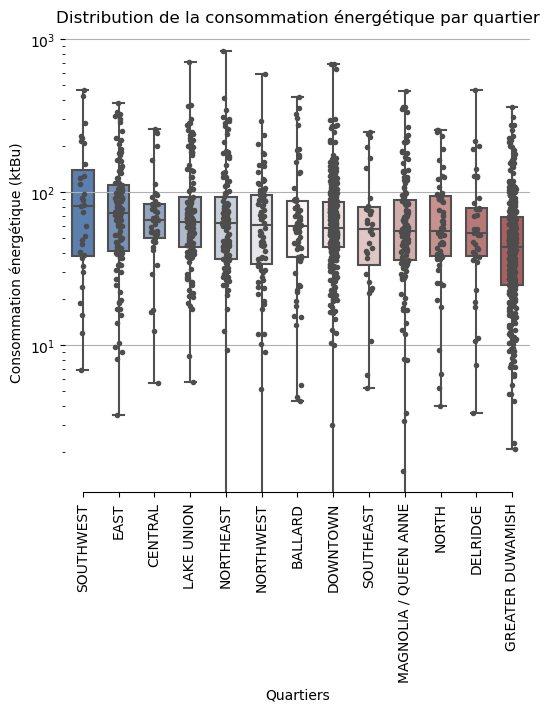

In [57]:
# Initialisationn de la figure avec un axe y en échelle log
f, ax = plt.subplots(figsize=(6, 6))
ax.set_yscale("log")

# Boxplot + points
order = df.groupby('Quartier')['Conso_norm'].median().sort_values(ascending=False).index
sns.boxplot(x="Quartier", y="Conso_norm", data=df, whis=[0, 100], width=.6, palette="vlag", order=order)
sns.stripplot(x="Quartier", y="Conso_norm", data=df,size=4, color=".3", linewidth=0, order=order)

# Présentation visuelle
ax.yaxis.grid(True)
ax.set(ylabel="Consommation énergétique (ktBu)", xlabel="Quartiers", title="Distribution de la consommation énergétique par quartier")
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)

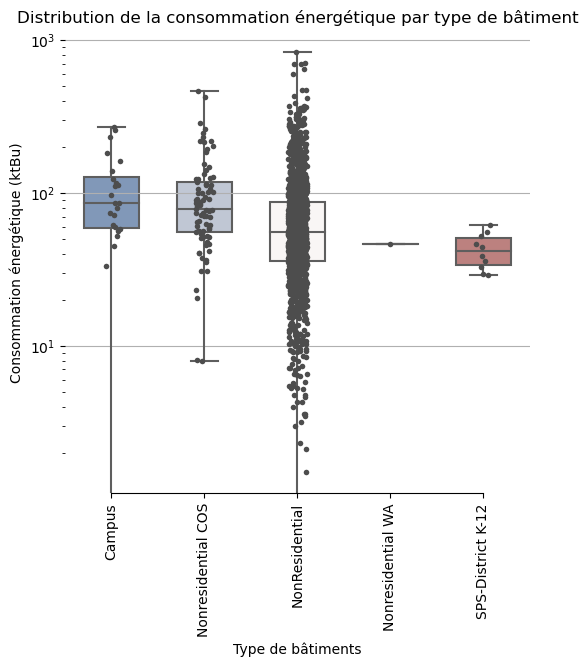

In [58]:
# Initialisationn de la figure avec un axe y en échelle log
f, ax = plt.subplots(figsize=(6, 6))
ax.set_yscale("log")

# Boxplot + points
order = df.groupby('Type_batiment')['Conso_norm'].median().sort_values(ascending=False).index
sns.boxplot(x="Type_batiment", y="Conso_norm", data=df, whis=[0, 100], width=.6, palette="vlag", order=order)
sns.stripplot(x="Type_batiment", y="Conso_norm", data=df,size=4, color=".3", linewidth=0, order=order)

# Présentation visuelle
ax.yaxis.grid(True)
ax.set(ylabel="Consommation énergétique (ktBu)", xlabel="Type de bâtiments", title="Distribution de la consommation énergétique par type de bâtiment")
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)

### Variables numériques VS numériques

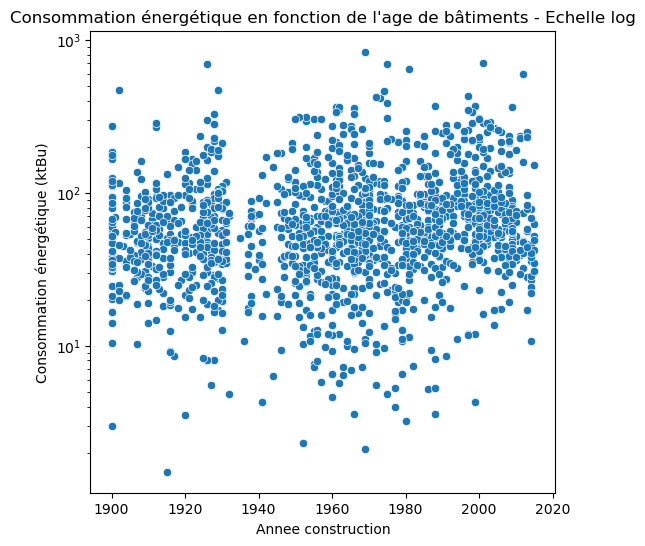

In [59]:
# Anne construction VS consommation
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(data=df, x="Annee_construction", y="Conso_norm")
plt.title("Consommation énergétique en fonction de l'age de bâtiments - Echelle log")
plt.xlabel("Annee construction")
plt.ylabel("Consommation énergétique (ktBu)")
ax.set_yscale('log')
plt.show()

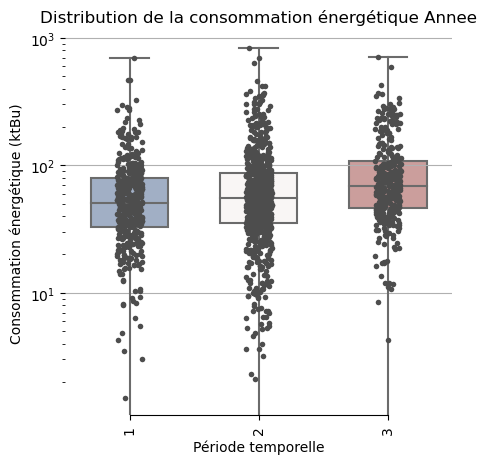

In [60]:
# Initialisationn de la figure avec un axe y en échelle log
f, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale("log")

# Boxplot + points
order = np.unique(df['Annee_cat'])
sns.boxplot(x="Annee_cat", y="Conso_norm", data=df, whis=[0, 100], width=.6, palette="vlag", order=order)
sns.stripplot(x="Annee_cat", y="Conso_norm", data=df,size=4, color=".3", linewidth=0, order=order)

# Présentation visuelle
ax.yaxis.grid(True)
ax.set(ylabel="Consommation énergétique (ktBu)", xlabel="Période temporelle", title="Distribution de la consommation énergétique Annee")
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)

Pas de schéma temporel à 100% visible malgré une légère tendance à l'augmentation comme le montre le boxplot sur les catégories ordinales d'années de construction. 

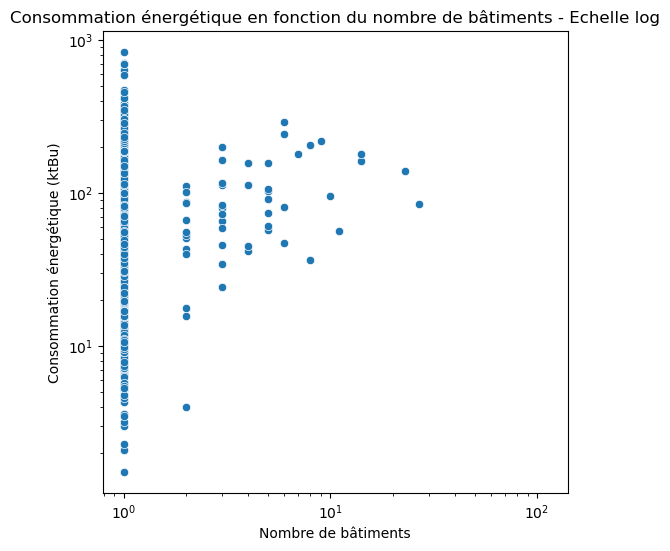

In [61]:
# Nombre de batiments VS consommation
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(data=df, x="Nb_batiments", y="Conso_norm")
plt.title("Consommation énergétique en fonction du nombre de bâtiments - Echelle log")
plt.xlabel("Nombre de bâtiments")
plt.ylabel("Consommation énergétique (ktBu)")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

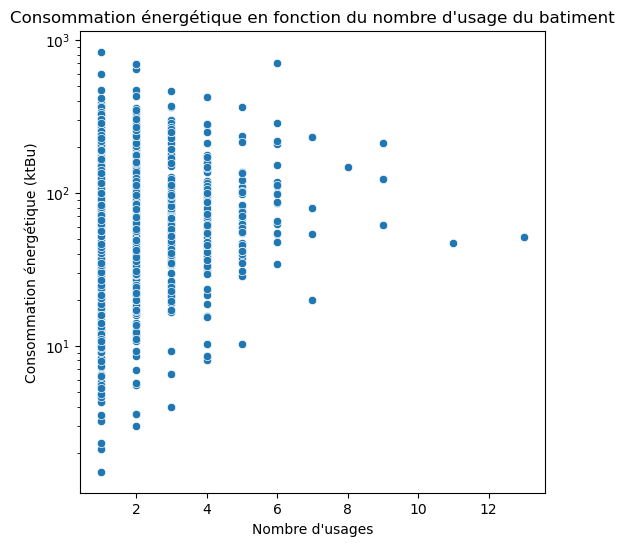

In [62]:
# Nb_usages VS consommation
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(data=df, x="Nb_usages", y="Conso_norm")
plt.title("Consommation énergétique en fonction du nombre d'usage du batiment")
plt.xlabel("Nombre d'usages")
plt.ylabel("Consommation énergétique (ktBu)")
ax.set_yscale('log')
plt.show()

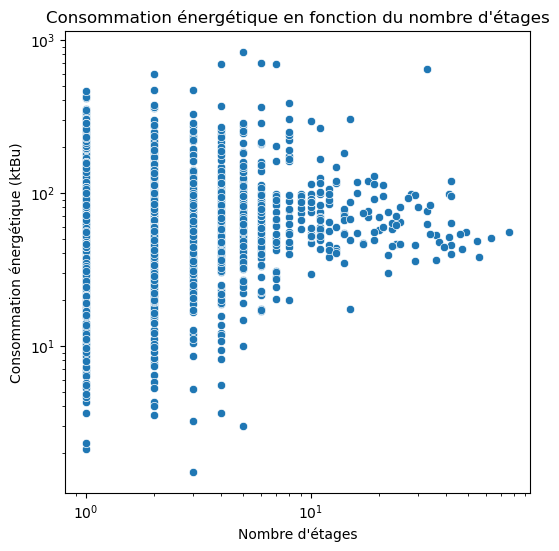

In [63]:
# Nombre d'étages" VS consommation
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(data=df, x="Nb_etages", y="Conso_norm")
plt.title("Consommation énergétique en fonction du nombre d'étages")
plt.xlabel("Nombre d'étages")
plt.ylabel("Consommation énergétique (ktBu)")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

Les propriétés présentant de nombreux bâtiments, de nombreux usages ou de nombreux étages ont tendance à consommer davanatage.

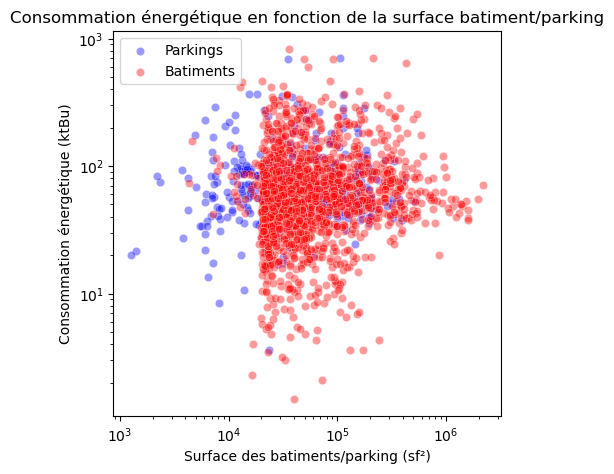

In [64]:
# Surface batiments VS consommation
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
sns.scatterplot(data=df, x="Surface_parking", y="Conso_norm", color='b', alpha=0.4, label='Parkings')
sns.scatterplot(data=df, x="Surface_batiment", y="Conso_norm", color='r', alpha=0.4, label='Batiments')
plt.title("Consommation énergétique en fonction de la surface batiment/parking")
plt.xlabel("Surface des batiments/parking (sf²)")
plt.ylabel("Consommation énergétique (ktBu)")
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.show()

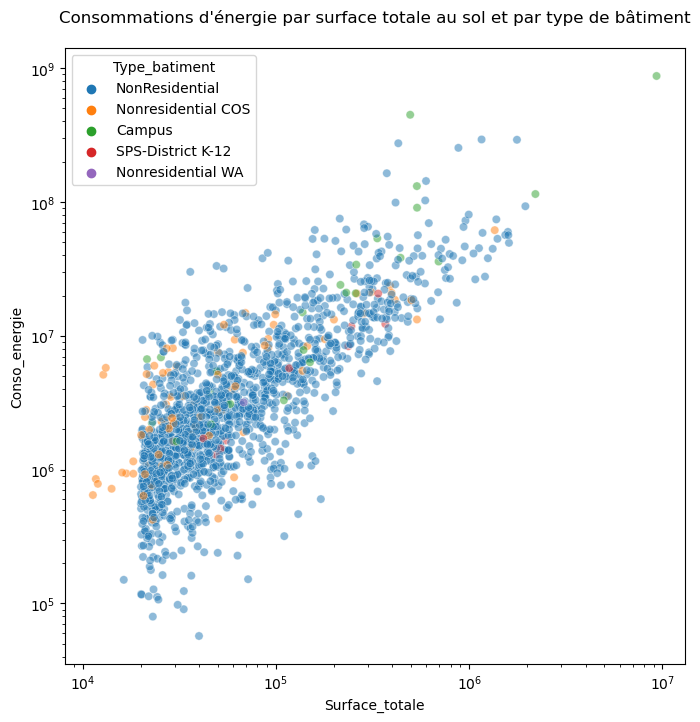

In [65]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data = df, x='Surface_totale', y='Conso_energie', hue='Type_batiment', alpha=0.5)
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [66]:
# Suppression du campus présentatn des valeurs extrêmes. Un bâtiment tel que celui-ci sera à gérer dans le futur comme une exception.
df = df[df['Conso_energie']<800000000]

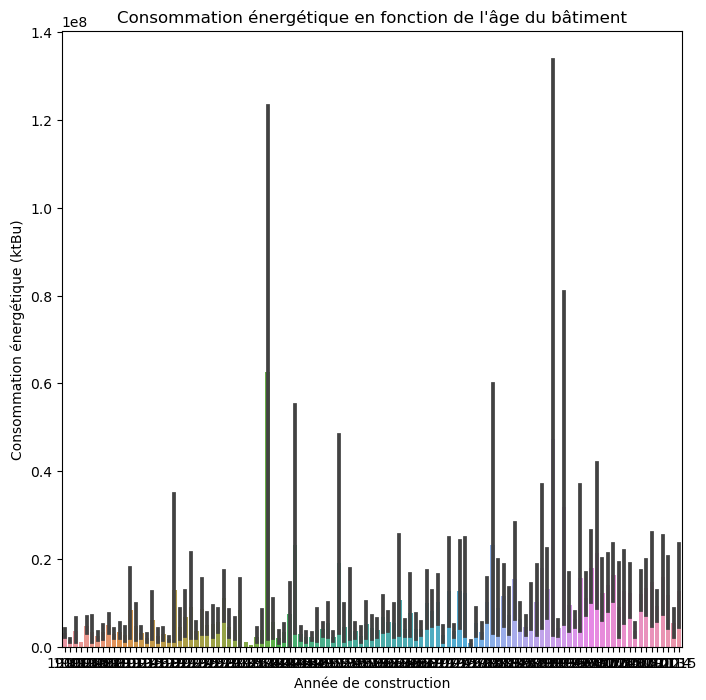

In [63]:
# Année de construction VS consommation
fig = plt.figure(figsize=(8,8))
sns.barplot(data=df, x="Annee_construction", y="Conso_energie_norm")
plt.title("Consommation énergétique en fonction de l'âge du bâtiment")
plt.xlabel("Année de construction")
plt.ylabel("Consommation énergétique (ktBu)")
plt.show()

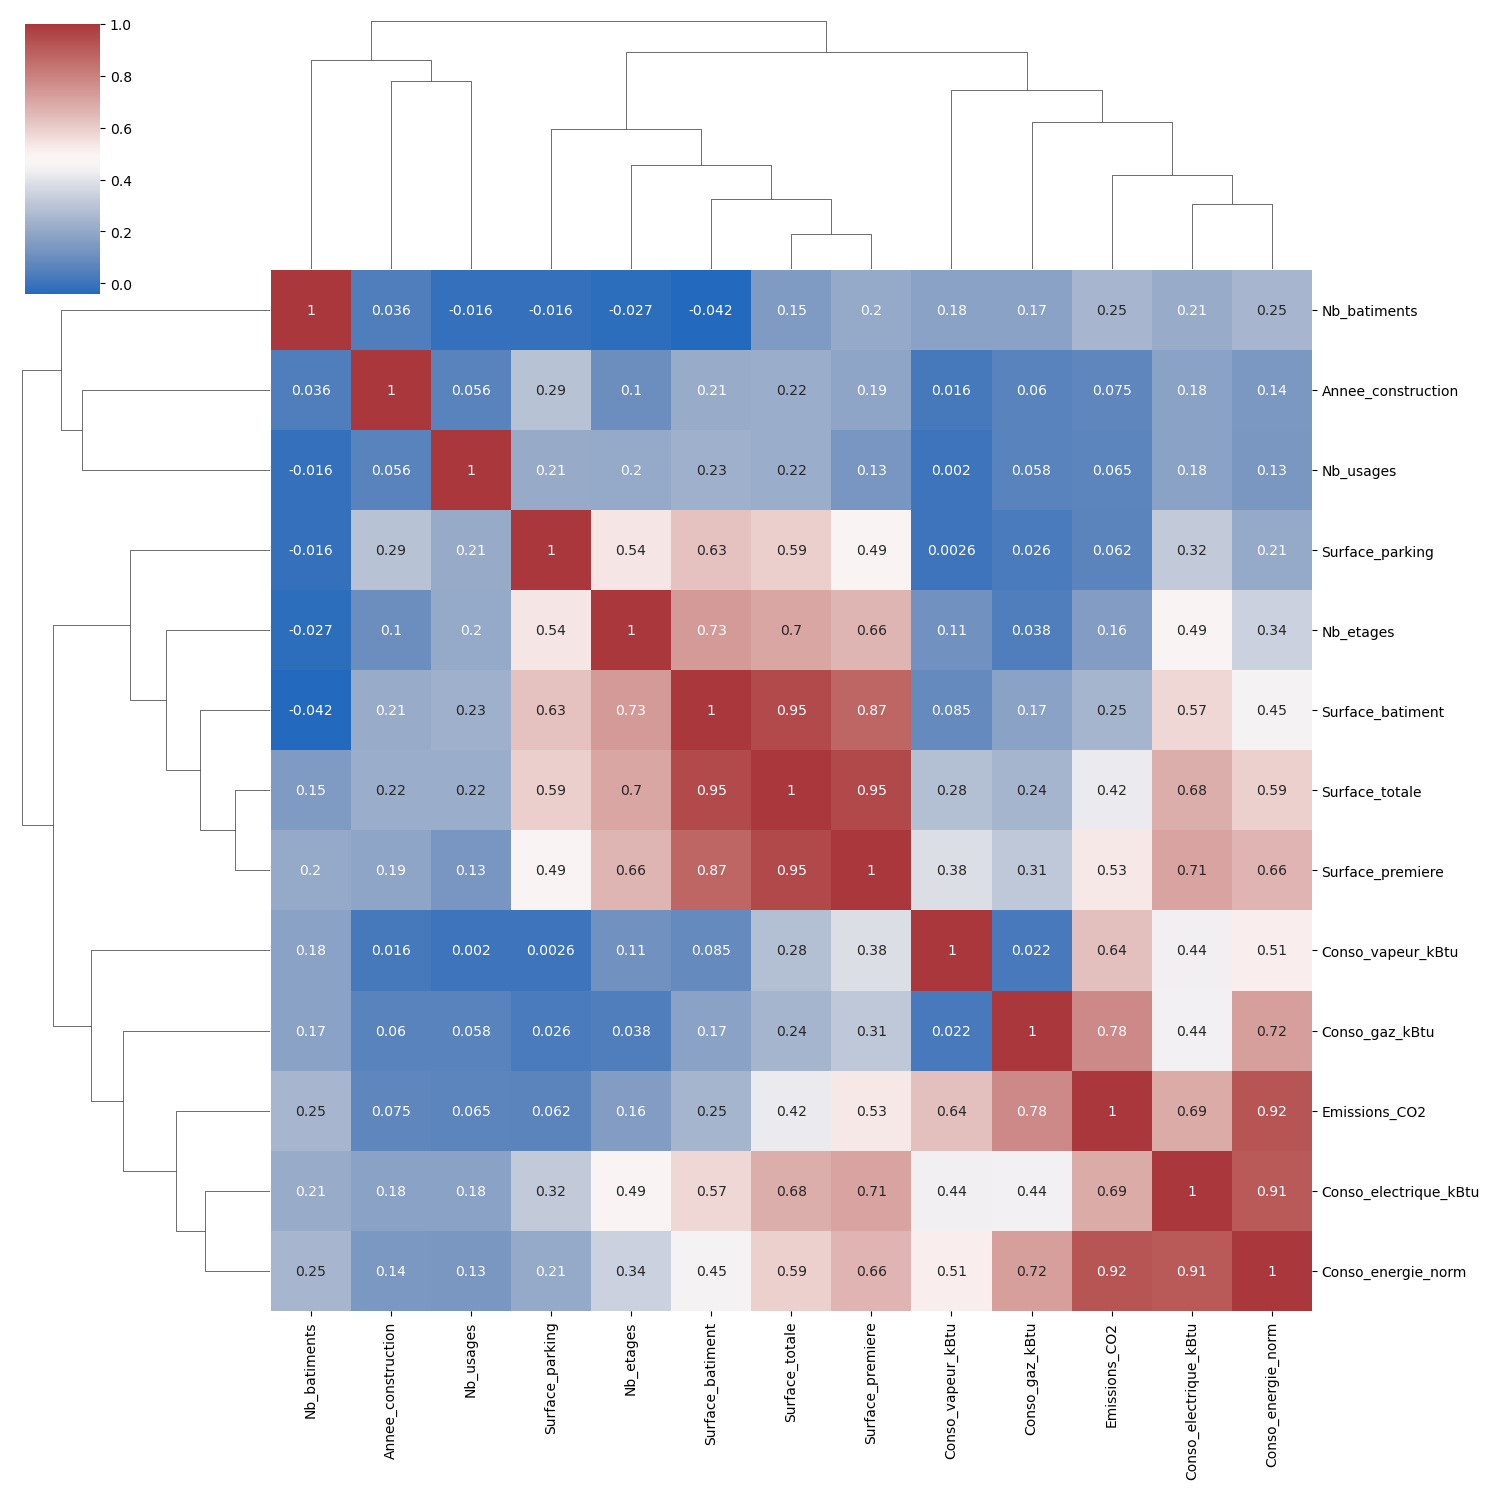

In [64]:
sns.clustermap(df[variables_num].corr(), annot=True, annot_kws={"fontsize":10}, figsize=(15, 15), cmap='vlag')

- Les caractéristiques qui dépendent de la taille des batiments (surface, batiment, surface totale, nb d'étages, ...etc) sont correlées relativement fortement à nos targets. 
- Les propriétés telles que l'age, la surface de parking, ...etc apparaissent moins importantes. 
- Les différents indicateurs de consommation sont logiquement très corrélés entre eux. Les concommations de gaz, vapeur, électricité ne peuvent cependant pas être prise en compte pour modéler la conosmmation totale.

In [65]:
# Heatmap classique avec la totalité des variables - Plus nécessaire, se référer à la clustermap ci-dessus
# corr = df.corr()
# # On affiche que le triangle du bas
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(17, 20))

# # Generate a custom diverging colormap
# #cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap="coolwarm",annot= True, fmt = ".2f", center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3.3. Analyse exploratoire du texte <a class="anchor" id="subchapter3.3"></a>

Une manière de visualiser de façon *high-level* des champs *textués* est de réaliser des nuages de mots. Dans ces nuages de mots, la taille des mots est proportionnelle à leur fréquence d'apparition. 
Cette représentation graphique implique un retraitement préalable de la liste de mots afin d'en retirer les mots inutiles.

Les 2 graphiques ci-dessous montrent 2 nuages de mots ; le premier correspond à la liste des adresses et le second correspond à la liste des noms de propriétés. L'exploration devra simplement permettre de vérifier si ces champs peuvent être exploitables ou non.

In [74]:
# Exploration visuelle des ingrédients sous forme de nuage de mots
# cette représentation permet la visualisation et l'analyse high-level d'un texte
from PIL import Image # librairie convertissant les images en array
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/151.4 kB ? eta -:--:--
                                              0.0/1

In [67]:
my_file = open("stopwords.txt", "r", encoding="utf-8")
STOPWORDS = my_file.readlines()
STOPWORDS = [i.replace('\n', '') for i in STOPWORDS]

In [68]:
# Création des variables "listes" pour y stocker les informations
liste_adresses = []
liste_nom_proprietes = []

In [69]:
# Fonction d'extraction des ingrédients et catégories
def extraction_info(texte):
    x = []
    if isinstance(texte, float):
        1
    else:
        x = texte.split(',')
#         x = [i.replace('-', ' ') for i in x]
#         x = [i.replace('_', '') for i in x]
    return x

In [70]:
# Application de la fonction à la colonne "Adresse"
df['Adresse'] = df['Adresse'].apply(extraction_info)
# Concatène les résultats
liste_adresses = np.concatenate(df['Adresse'].to_list())
liste_adresses_str = ', '.join(liste_adresses)

# Application de la fonction à la colonne "Nom_propriete"
df['Nom_propriete'] = df['Nom_propriete'].apply(extraction_info)
# Concatène les résultats
liste_nom_proprietes = np.concatenate(df['Nom_propriete'].to_list())
liste_nom_proprietes_str = ', '.join(liste_nom_proprietes)

In [71]:
stopword = set(STOPWORDS)

In [72]:
# instantiate a word cloud object
Nuage_mots = WordCloud(width=1600, height=800, background_color='white', max_words=800, stopwords=stopword)
# generate the word cloud
Nuage_mots.generate(liste_adresses_str)

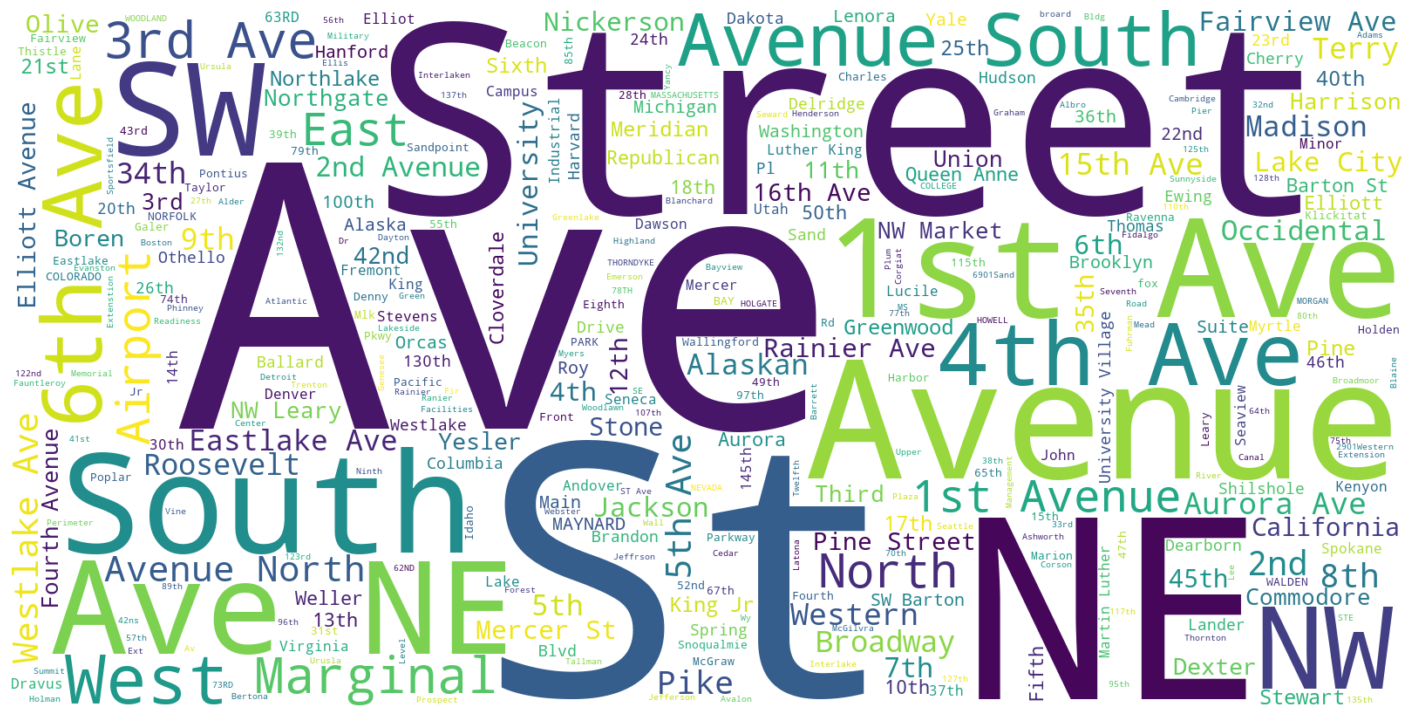

In [73]:
# display the word cloud
plt.figure(figsize=(18,18))
plt.imshow(Nuage_mots, interpolation='bilinear')
plt.axis('off')
plt.show()

In [74]:
# instantiate a word cloud object
Nuage_mots = WordCloud(width=1600, height=800, background_color='white', max_words=800, stopwords=stopword)
# generate the word cloud
Nuage_mots.generate(liste_nom_proprietes_str)

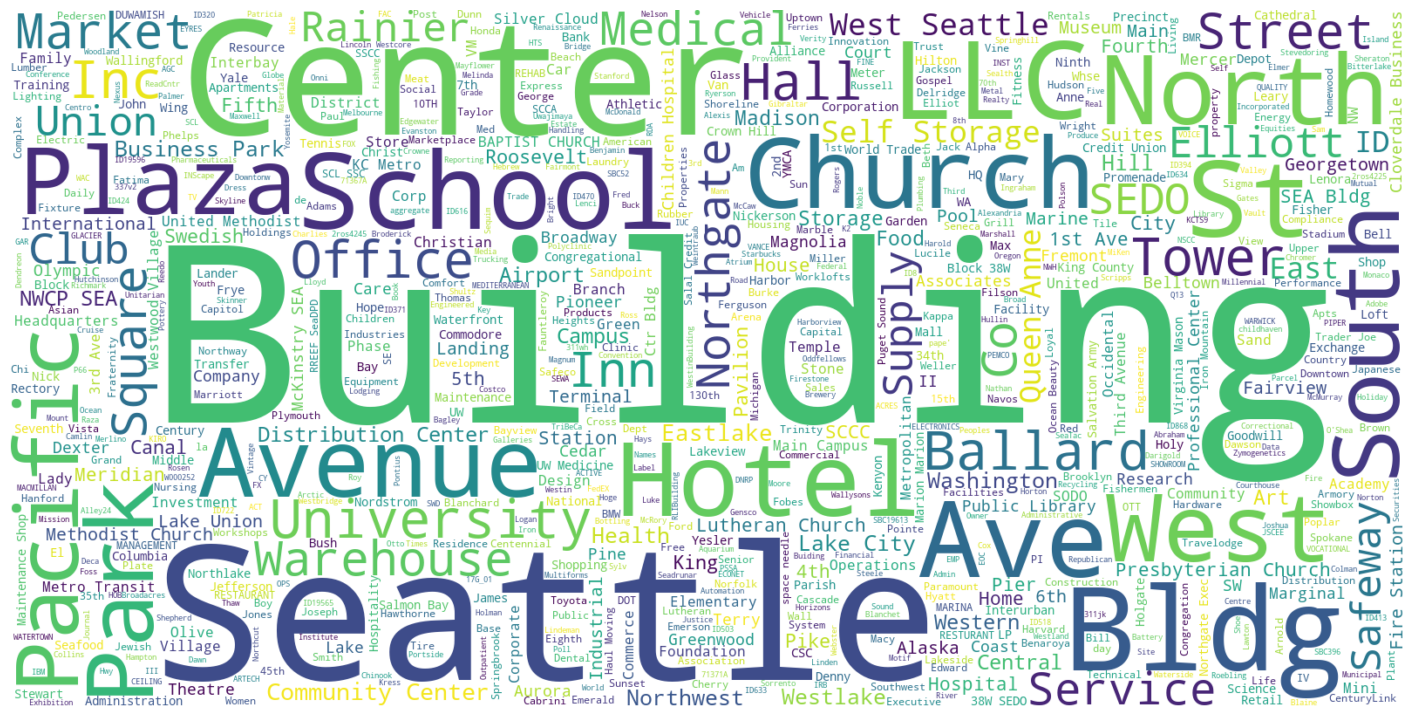

In [75]:
# display the word cloud
plt.figure(figsize=(18,18))
plt.imshow(Nuage_mots, interpolation='bilinear')
plt.axis('off')
plt.show()

Il est difficile de déduire es informations pertinentes du nom des propriétés. Tower, Building, Center, Plaza sont des termes indiquant une grande hauteur ou une grande surface, mais ces informations doivent pouvoir être identifiées via les autres variables du dataset.

# 4. Première modélisation <a class="anchor" id="chapter4"></a>

Le but de ce chapitre est de réaliser un premier exercice de modélisation à l'aide d'un modèle simple basique. 
Ce premier exercice de modélisation sera fera à l'aide de 2 modèles :
- Un *dummy regressor*.
- Un *modèle mutli-linéaire*.

Cette approche présente un double intérêt : 
- Avoir un score de base qui servira de référence pour estimer les futurs modèles.
- Identifier les premières tendances afin de réaliser un feature engineering avancé. 

Pour cette première estimation, le choix est fait de se concentrer sur la variable "**conso_energie_norm**". Cette variable étant fortement corrélée avec celle liées aux émissions de CO2. Créer un premier modèle de la première approximera relativement bien la seconde.

In [76]:
Target = 'Conso_energie_norm'

In [77]:
# Import des modules d'intérêts dans scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import * # Metrics de mesure de la performance
from sklearn.metrics import make_scorer # Creation d'une metric personnalisée
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate  
from sklearn.model_selection import validation_curve

## 4.1. Evaluation de la performance et choix des *metrics* <a class="anchor" id="subchapter4.1"></a>

Plusieurs *metrics* (= indicateurs) vont être utilisées pour calculer la performance du modèle :
- Le score R² : coefficient de détermination qui est le rapport la variance expliquée par le modèle et la variance globale des données.
- Le score MAE : **M**ean **A**bsolute **E**rror, qui correspond à la moyenne des erreurs absolues.
- Le score RMSE : **R**oot **M**ean **S**quare **E**rror, qui correspond à la racine moyenne des écarts quadratiques. 

Enfin, à ces 3 *metrics*, le choix est fait de rajouter un indicateur personnalisé. Il se définit comme étant le pourcentage de prédictions qui se trouvent dans un intervalle +/-5% de la valeur réelle
Cette *metric* est intéressante car elle est plus facilement compréhensible par les intevenants qui n'auraient pas d'expertise en *Machine Learning*. Elle permet ainsi de traduire plus simplement notre problématique à l'attention des non-experts.

In [78]:
# Définition de la fonction de calcul de la metric personnalisée qui correspond à une précision des prédictions de +/-5%
def custom_metric(y, y_pred):
    y = y.values
    resultat = np.sum((y_pred < (y * 1.05)) & (y_pred > (y * 0.95)))/y.size
    return resultat

In [79]:
# Création du score de performance associé à la metric "custom_metric"
custom_score = make_scorer(custom_metric, greater_is_better=True)

In [80]:
scoring= {
        'r2':'r2',
        'neg_root_mean_squared_error':'neg_root_mean_squared_error', 
        'neg_mean_absolute_error':'neg_mean_absolute_error',
        'custom_metric':make_scorer(custom_metric),
    }

In [81]:
df_resultats = pd.DataFrame(columns=['Modele', 'Train_R2', 'Val_R2', 'Train_RMSE', 'Val_RMSE', 'Train_MAE', 'Val_MAE', 'Train_custom', 'Val_custom', 'Temps_execution', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom'])

## 4.2. Application d'un modèle de régression multi-linéaire <a class="anchor" id="subchapter4.2"></a>

In [82]:
df_modele_basique = df.copy()

In [83]:
Var_modele = ['Quartier', 'Type_batiment', 'Annee_construction', 'Nb_batiments', 'Nb_etages', 
              'Pourcent_parking', 'Pourcent_elec', 'Pourcent_gaz', 'Pourcent_vapeur', 'Nb_usages', Target]
df_modele_basique = df_modele_basique[Var_modele]

In [84]:
# Application d'un OneHotEncoder sur les variables catégorielles
var_qualitatives = ['Quartier', 'Type_batiment']
df_modele_basique = pd.get_dummies(df_modele_basique, columns = var_qualitatives)

In [85]:
# Création des datasets X(=features) et y (=target)
y = df_modele_basique[Target]
X = df_modele_basique.drop(Target, axis=1)

In [86]:
# Création du train_set et du test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

Le modèle basique retenu étant un simple modèle de régression linéaire, il n'y a pas réellement d'hyperparamètres à optimiser. Cependant, il est possible d'appliquer une validation croisée pour visuliser l'effet de la stratification de la validation croisée sur la performance du modèle.

In [87]:
start = time.time()
modele_basique_1 = LinearRegression()
modele_basique_1.fit(X_train, y_train)
end = time.time()
Duree_execution = end - start

In [88]:
resultat_r2 = cross_val_score(modele_basique_1, X_train, y_train, cv=10, scoring='r2')
resultat_r2

array([ 3.76271789e-01,  1.43350731e-01, -1.31904582e+00,  2.84514634e-01,
        3.70201850e-01,  4.07782746e-01,  1.81434232e-01, -5.04564742e-04,
       -5.49556342e-01,  1.30361275e-01])

le score R² de cross_validation sur le *train_set* n'est pas du tout reproductible et varie énormément, ce qui prouve que (sur la base du *dataset* actuel) le modèle n'est pas en mesure d'apprendre correctement.

In [89]:
# Calcul du score de cross_validation
score = cross_validate(modele_basique_1, X, y, cv=10, scoring = scoring, return_train_score = True)

In [91]:
for i in scoring:
    scrore_name = "train_{0}".format(i)
    print("Le score moyen {0} est de {1:.3f}".format(scrore_name, round(score[scrore_name].mean(),3)))
    scrore_name = "test_{0}".format(i)
    print("Le score moyen {0} est de {1:.3f}".format(scrore_name, round(score[scrore_name].mean(),3)))

Le score moyen train_r2 est de 0.244
Le score moyen test_r2 est de -0.634
Le score moyen train_neg_root_mean_squared_error est de -19755822.979
Le score moyen test_neg_root_mean_squared_error est de -16813420.052
Le score moyen train_neg_mean_absolute_error est de -7149946.186
Le score moyen test_neg_mean_absolute_error est de -7672993.729
Le score moyen train_custom_metric est de 0.033
Le score moyen test_custom_metric est de 0.021


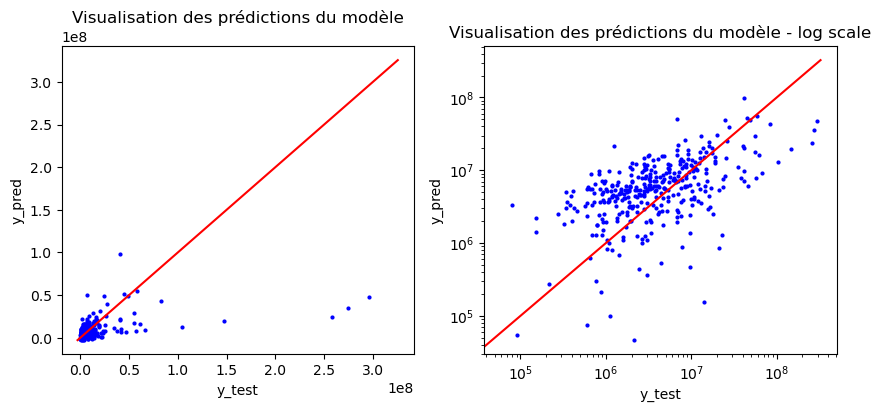

In [92]:
y_pred = modele_basique_1.predict(X_test)
# Affichage de la courbe y_test / y_pred
maximum = max(max(y_test), max(y_pred)) * 1.1
minimum = min(min(y_test), min(y_pred)) * 1.1
droite = np.linspace(minimum,maximum,10)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(y_test, y_pred, 'bo', markersize= 2)
plt.plot(droite, droite, 'r')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Visualisation des prédictions du modèle")
plt.subplot(1,2,2)
plt.plot(y_test, y_pred, 'bo', markersize= 2)
plt.plot(droite, droite, 'r')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Visualisation des prédictions du modèle - log scale")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [93]:
dict_resultat = {
    'Modele':'modele_basique_1',
    'Train_R2':np.expm1(score['train_r2'].mean()),
    'Train_RMSE':np.expm1(score['train_neg_root_mean_squared_error'].mean()),
    'Train_MAE':np.expm1(score['train_neg_mean_absolute_error'].mean()),
    'Train_custom':np.expm1(score['train_custom_metric'].mean()),
    'Temps_execution':Duree_execution,
    'Test_R2':np.expm1(score['test_r2'].mean()),
    'Test_RMSE':np.expm1(score['test_neg_root_mean_squared_error'].mean()),
    'Test_MAE':score['test_neg_mean_absolute_error'].mean(),
    'Test_custom':score['test_custom_metric'].mean(),
}
df_resultats = df_resultats.append(dict_resultat, ignore_index=True)

In [94]:
print("On constate que ce premier modèle basique n'est pas du tout performant dans sa capacité de généralisation. Le score R² sur le test set étant de {0:.3f}.".format(score['test_r2'].mean()))

On constate que ce premier modèle basique n'est pas du tout performant dans sa capacité de généralisation. Le score R² sur le test set étant de -0.634.


Selon la *metric* personnalisée seul 6% environ des prédictions se trouvent dans un intervalle de confiance de +/-5% de la valeur réelle.

**Conclusions:**
Les coefficients R² sont extrêmement variables et la peformance du modèle n'est pas bonne. Plusieurs raisons permettent d'expliquer cela :
- Le modèle n'arrive pas à apprendre car il n'a pas assez de données.
- La régression multi-linéaire n'est pas adaptée à notre problématique.
- Le processus de cross-validation manipule des groupes non homogènes.
- Le feature engineering est à revoir car les variables ne sont pas assez pertinentes ou insufisamment préparées (Normalité).
- Les points extrêmes pour lesquels les prédictions sous-estiment largement les valeurs du *test_set*. Ceci est surement du à la présence de valeurs extrêmement élevées dans le dataset.

**Orientations:**
Les orientations pour la suite de l'analyse sont donc les suivantes : 
- Poursuivre l'effort de feature engineering, en optimisant les variables existantes (transformation log) et en en créant de nouvelles.
- Optimiser la cross-validation, avec par exemple un ShuffleSplit
- Tester d'autres modèles que la régression multi-linéaire (modèles non-linéaires et ensemblistes)

## 4.3. Application d'un modèle dummy_regressor <a class="anchor" id="subchapter4.3"></a>

Un second modèle basique appelé le dummy regressor aété appliqué. 
Il s'agit d'un modèle extrêmement simple, de type naïf, qui prédit les valeurs *y_pred* à partir des statistiques descriptives simples (par ex : moyenne, médiane, ...etc) du *train_set*.

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
# Paramètres à optimiser alpha = quantitle
params = {
    "quantile":np.arange(0,1,0.1)
}

In [97]:
start = time.time()
Modele_basique_2 = DummyRegressor(strategy="mean")
grid = GridSearchCV(Modele_basique_2, param_grid = params, scoring = 'r2', cv=10)
grid.fit(X_train, y_train)
Modele_basique_2 = grid.best_estimator_
end = time.time()
Duree_execution = end - start

In [98]:
resultat_r2 = cross_val_score(modele_basique_1, X_train, y_train, cv=10, scoring='r2')
resultat_r2

array([ 3.76271789e-01,  1.43350731e-01, -1.31904582e+00,  2.84514634e-01,
        3.70201850e-01,  4.07782746e-01,  1.81434232e-01, -5.04564742e-04,
       -5.49556342e-01,  1.30361275e-01])

le score R² de cross_validation sur le *train_set* n'est pas du tout reproductible et varie énormément, ce qui prouve que (sur la base du *dataset* actuel) le modèle n'est pas en mesure d'apprendre correctement.

In [99]:
# Calcul du score de cross_validation
score = cross_validate(Modele_basique_2, X, y, cv=10, scoring = scoring, return_train_score = True)

In [100]:
for i in scoring:
    scrore_name = "train_{0}".format(i)
    print("Le score moyen {0} est de {1:.3f}".format(scrore_name, round(score[scrore_name].mean(),3)))
    scrore_name = "test_{0}".format(i)
    print("Le score moyen {0} est de {1:.3f}".format(scrore_name, round(score[scrore_name].mean(),3)))

Le score moyen train_r2 est de 0.000
Le score moyen test_r2 est de -0.796
Le score moyen train_neg_root_mean_squared_error est de -22689033.831
Le score moyen test_neg_root_mean_squared_error est de -18584278.289
Le score moyen train_neg_mean_absolute_error est de -9043791.309
Le score moyen test_neg_mean_absolute_error est de -9306662.575
Le score moyen train_custom_metric est de 0.021
Le score moyen test_custom_metric est de 0.021


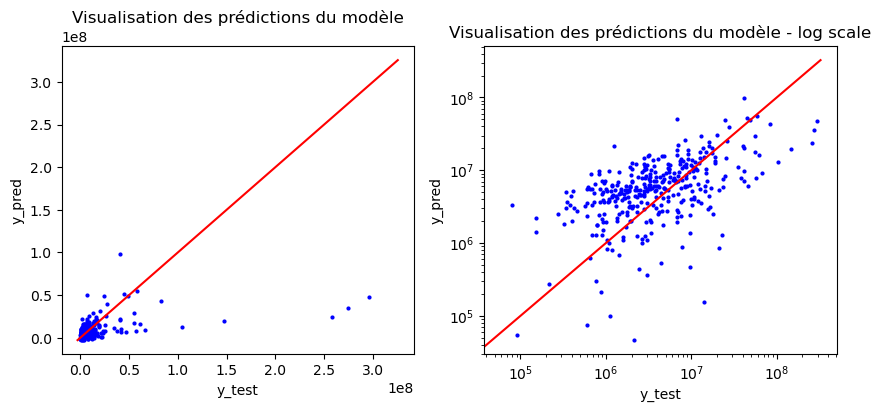

In [101]:
y_pred = modele_basique_2.predict(X_test)
# Affichage de la courbe y_test / y_pred
maximum = max(max(y_test), max(y_pred)) * 1.1
minimum = min(min(y_test), min(y_pred)) * 1.1
droite = np.linspace(minimum,maximum,10)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(y_test, y_pred, 'bo', markersize= 2)
plt.plot(droite, droite, 'r')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Visualisation des prédictions du modèle")
plt.subplot(1,2,2)
plt.plot(y_test, y_pred, 'bo', markersize= 2)
plt.plot(droite, droite, 'r')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Visualisation des prédictions du modèle - log scale")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [102]:
dict_resultat = {
    'Modele':'modele_basique_2 (Dummy regr.)',
    'Train_R2':np.expm1(score['train_r2'].mean()),
    'Train_RMSE':np.expm1(score['train_neg_root_mean_squared_error'].mean()),
    'Train_MAE':np.expm1(score['train_neg_mean_absolute_error'].mean()),
    'Train_custom':np.expm1(score['train_custom_metric'].mean()),
    'Temps_execution':Duree_execution,
    'Test_R2':score['test_r2'].mean(),
    'Test_RMSE':np.expm1(score['test_neg_root_mean_squared_error'].mean()),
    'Test_MAE':np.expm1(score['test_neg_mean_absolute_error'].mean()),
    'Test_custom':np.expm1(score['test_custom_metric'].mean()),
}
df_resultats = df_resultats.append(dict_resultat, ignore_index=True)

Sans surprise, le modèle n'est pas du tout adapté. Ni l'entrainement, ni la généralisation ne fonctionnent correctement.

# 5. *Feature engineering* avancé <a class="anchor" id="chapter5"></a>

## 5.1. Analyse de l'asymétrie des variables numérique <a class="anchor" id="subchapter5.1"></a>

Il est possible de caractériser l'allure d'une distribution à travers 2 critères :
- le score de skewness (=asymétrie de la distribution)
- le score de Kurtosis (=aplatissement de la distribution).

In [103]:
# Import des modules skew et kurtosis de la librairie scipy
from scipy.stats import skew
from scipy.stats import kurtosis

In [104]:
df_stats = df.copy()

In [105]:
Var_numeriques = ['Annee_cat', 'Nb_batiments', 'Nb_etages', 'Pourcent_parking', 'Pourcent_elec', 'Pourcent_gaz', 'Pourcent_vapeur', 'Nb_usages', Target]

In [106]:
my_list = []
for idi, i in enumerate(Var_numeriques):
    my_list.append([i, skew(df_stats[Var_numeriques], axis=0, bias=True, nan_policy='omit')[idi], kurtosis(df_stats[Var_numeriques], axis=0, bias=True, nan_policy='omit')[idi]])

In [107]:
# Affichage de la liste tabulée
print(tabulate(my_list, headers=["Variables", "Score de Skewness", "Score de Kurtosis"], numalign="center"))

Variables            Score de Skewness    Score de Kurtosis
------------------  -------------------  -------------------
Annee_cat                0.100634              -1.0799
Nb_batiments              14.1422              249.532
Nb_etages                 5.03179              33.2306
Pourcent_parking          2.36428              5.42514
Pourcent_elec            -0.356393            -1.05635
Pourcent_gaz             0.505072             -0.980667
Pourcent_vapeur           4.55185              20.9571
Nb_usages                 2.23161              8.87149
Conso_energie_norm        10.9098              165.792


On constate que plusieurs variables présentent une forte asymétrie : 
- Le nombre de bâtiments
- Le nombre d'étages
- Le pourcentage de vapeur
- La target "Conso_energie_norm"

Ces variables devront faire l'objet d'une transformation logarithmique pour les futures modélisations.

## 5.2. Travail sur la notion usage des bâtiments <a class="anchor" id="subchapter5.2"></a>

L'exploration des données a montré que la variable *Type_batiment* n'était pas suffisamment précise pour prédire convenablement nos données. Il convient donc de rechercher dles différents types d'usages de batiment et de les regrouper de manière logique et optimisée.

In [108]:
# Extraction des différents usages présents dans le dataset
liste_1 = df['Usage_premier'].unique()
liste_2 = df['Usage_second'].unique()
liste_3 = df['Usage_tiers'].unique()
liste_usages = [*liste_1, *liste_2, *liste_3]
liste_usages = np.unique(liste_usages)

In [109]:
print("Il existe dans le dataset {0} usages différents. \nLes valeurs uniques d'usage des bâtiments sont :\n{1}".format(len(liste_usages), liste_usages))

Il existe dans le dataset 64 usages différents. 
Les valeurs uniques d'usage des bâtiments sont :
['Adult Education' 'Automobile Dealership' 'Bank Branch' 'Bar/Nightclub'
 'College/University' 'Convenience Store without Gas Station' 'Courthouse'
 'Data Center' 'Distribution Center' 'Enclosed Mall'
 'Fast Food Restaurant' 'Financial Office' 'Fire Station'
 'Fitness Center/Health Club/Gym' 'Food Sales' 'Food Service'
 'Hospital (General Medical & Surgical)' 'Hotel' 'K-12 School'
 'Laboratory' 'Library' 'Lifestyle Center'
 'Manufacturing/Industrial Plant' 'Medical Office' 'Movie Theater'
 'Multifamily Housing' 'Museum' 'Non-Refrigerated Warehouse' 'Office'
 'Other' 'Other - Education' 'Other - Entertainment/Public Assembly'
 'Other - Lodging/Residential' 'Other - Mall' 'Other - Public Services'
 'Other - Recreation' 'Other - Restaurant/Bar' 'Other - Services'
 'Other - Technology/Science' 'Other - Utility' 'Other/Specialty Hospital'
 'Parking' 'Performing Arts'
 'Personal Services (Health

puisqu'il y'a trop d'usages(64) on ne peut pas faire le one-hoe encoder si non on va tout gaté on aura trop de features en plus. 
on fait donc un regroupement en catégories

In [110]:
# Création d'un dictionnaire des usages. Keys = "Usage" | Values = "Categorie"
dict_usages = {
    'College/University':'Education', 
    'Adult Education':'Education', 
    'Pre-school/Daycare':'Education', 
    'Vocational School':'Education', 
    'Other - Education':'Education', 
    'K-12 School':'Education',
    'Bar/Nightclub':'Div_Public',
    'Library':'Div_Public', 
    'Lifestyle Center':'Div_Public', 
    'Movie Theater':'Div_Public', 
    'Performing Arts':'Div_Public', 
    'Swimming Pool':'Div_Public',
    'Museum':'Div_Public', 
    'Courthouse':'Div_Public', 
    'Other - Recreation':'Div_Public', 
    'Police Station':'Div_Public', 
    'Fitness Center/Health Club/Gym':'Div_Public',
    'Other - Entertainment/Public Assembly':'Div_Public', 
    'Other - Public Services':'Div_Public',
    'Other':'Div_Public',
    'Convenience Store without Gas Station':'Magasin', 
    'Personal Services (Health/Beauty, Dry Cleaning, etc)':'Magasin', 
    'Strip Mall':'Magasin', 
    'Enclosed Mall':'Magasin', 
    'Retail Store':'Magasin', 
    'Social/Meeting Hall':'Magasin', 
    'Supermarket/Grocery Store':'Supermarche',
    'Wholesale Club/Supercenter':'Magasin', 
    'Automobile Dealership':'Magasin', 
    'Food Sales':'Magasin', 
    'Repair Services (Vehicle, Shoe, Locksmith, etc)':'Magasin', 
    'Other - Mall':'Magasin',
    'Food Service':'Restauration',
    'Restaurant':'Restauration', 
    'Fast Food Restaurant':'Restauration', 
    'Other - Restaurant/Bar':'Restauration',
    'Financial Office':'Services', 
    'Office':'Services', 
    'Bank Branch':'Services', 
    'Other - Utility':'Services', 
    'Other - Services':'Services',
    'Data Center':'Tech', 
    'Other - Technology/Science':'Tech',
    'Laboratory':'Tech',
    'Hospital (General Medical & Surgical)':'Medical', 
    'Urgent Care/Clinic/Other Outpatient':'Medical',
    'Other/Specialty Hospital':'Medical', 
    'Residential Care Facility':'Medical', 
    'Hospital (General Medical & Surgical)':'Medical',
    'Hotel':'Hotel',
    'Senior Care Community':'Soin',
    'Medical Office':'Soin',
    'Manufacturing/Industrial Plant':'Industriel',
    'Refrigerated Warehouse':'Industriel', 
    'Non-Refrigerated Warehouse':'Industriel', 
    'Fire Station':'Industriel', 
    'Distribution Center':'Industriel',
    'Parking':'Parking', 
    'Self-Storage Facility':'Box_stockage',
    'Prison/Incarceration':'Residentiel', 
    'Residence Hall/Dormitory':'Residentiel', 
    'Multifamily Housing':'Residentiel', 
    'Other - Lodging/Residential':'Residentiel',
    'Worship Facility':'Lieu_culte',
}

In [111]:
# Création de colonnes dans le dataframe correspondant aux différentes catégories d'usage
my_liste = []
my_liste = list(dict_usages.values())
liste_util = list(np.unique(my_liste))
for i in np.unique(my_liste):
    df[i] = 0

In [112]:
# Affecter des proprotions de surface à chaque catégorie d'usage
for j in dict_usages.keys():
    df.loc[df['Usage_premier'] == j, dict_usages[j]] = df.loc[df['Usage_premier'] == j, dict_usages[j]] + df.loc[df['Usage_premier'] == j, 'Surface_premiere'] / df.loc[df['Usage_premier'] == j, 'Surface_totale']
    df.loc[df['Usage_second'] == j, dict_usages[j]] = df.loc[df['Usage_second'] == j, dict_usages[j]] + df.loc[df['Usage_second'] == j, 'Surface_second'] / df.loc[df['Usage_second'] == j, 'Surface_totale']
    df.loc[df['Usage_tiers'] == j, dict_usages[j]] = df.loc[df['Usage_tiers'] == j, dict_usages[j]] + df.loc[df['Usage_tiers'] == j, 'Surface_tiers'] / df.loc[df['Usage_tiers'] == j, 'Surface_totale']

In [113]:
df['Categorie'] = df['Usage_premier']
df = df.replace({'Categorie':dict_usages})

Afin de vérifier la pertinence des choix réalisés pour cette opération de catégorisation, un diagramme de boxplot est affiché. Il présente la distribution des batiments par usage (*stripplot*) et par catégorie (*boxplot*). Ce type de diagramme permet de confirmer que nos catégories sont cohérentes d'un point de vue logique, mais aussi d'un point de vue mathématique. La variance intra-catégorie doit être la plus faible possible pour limiter la variance dans le modèle.

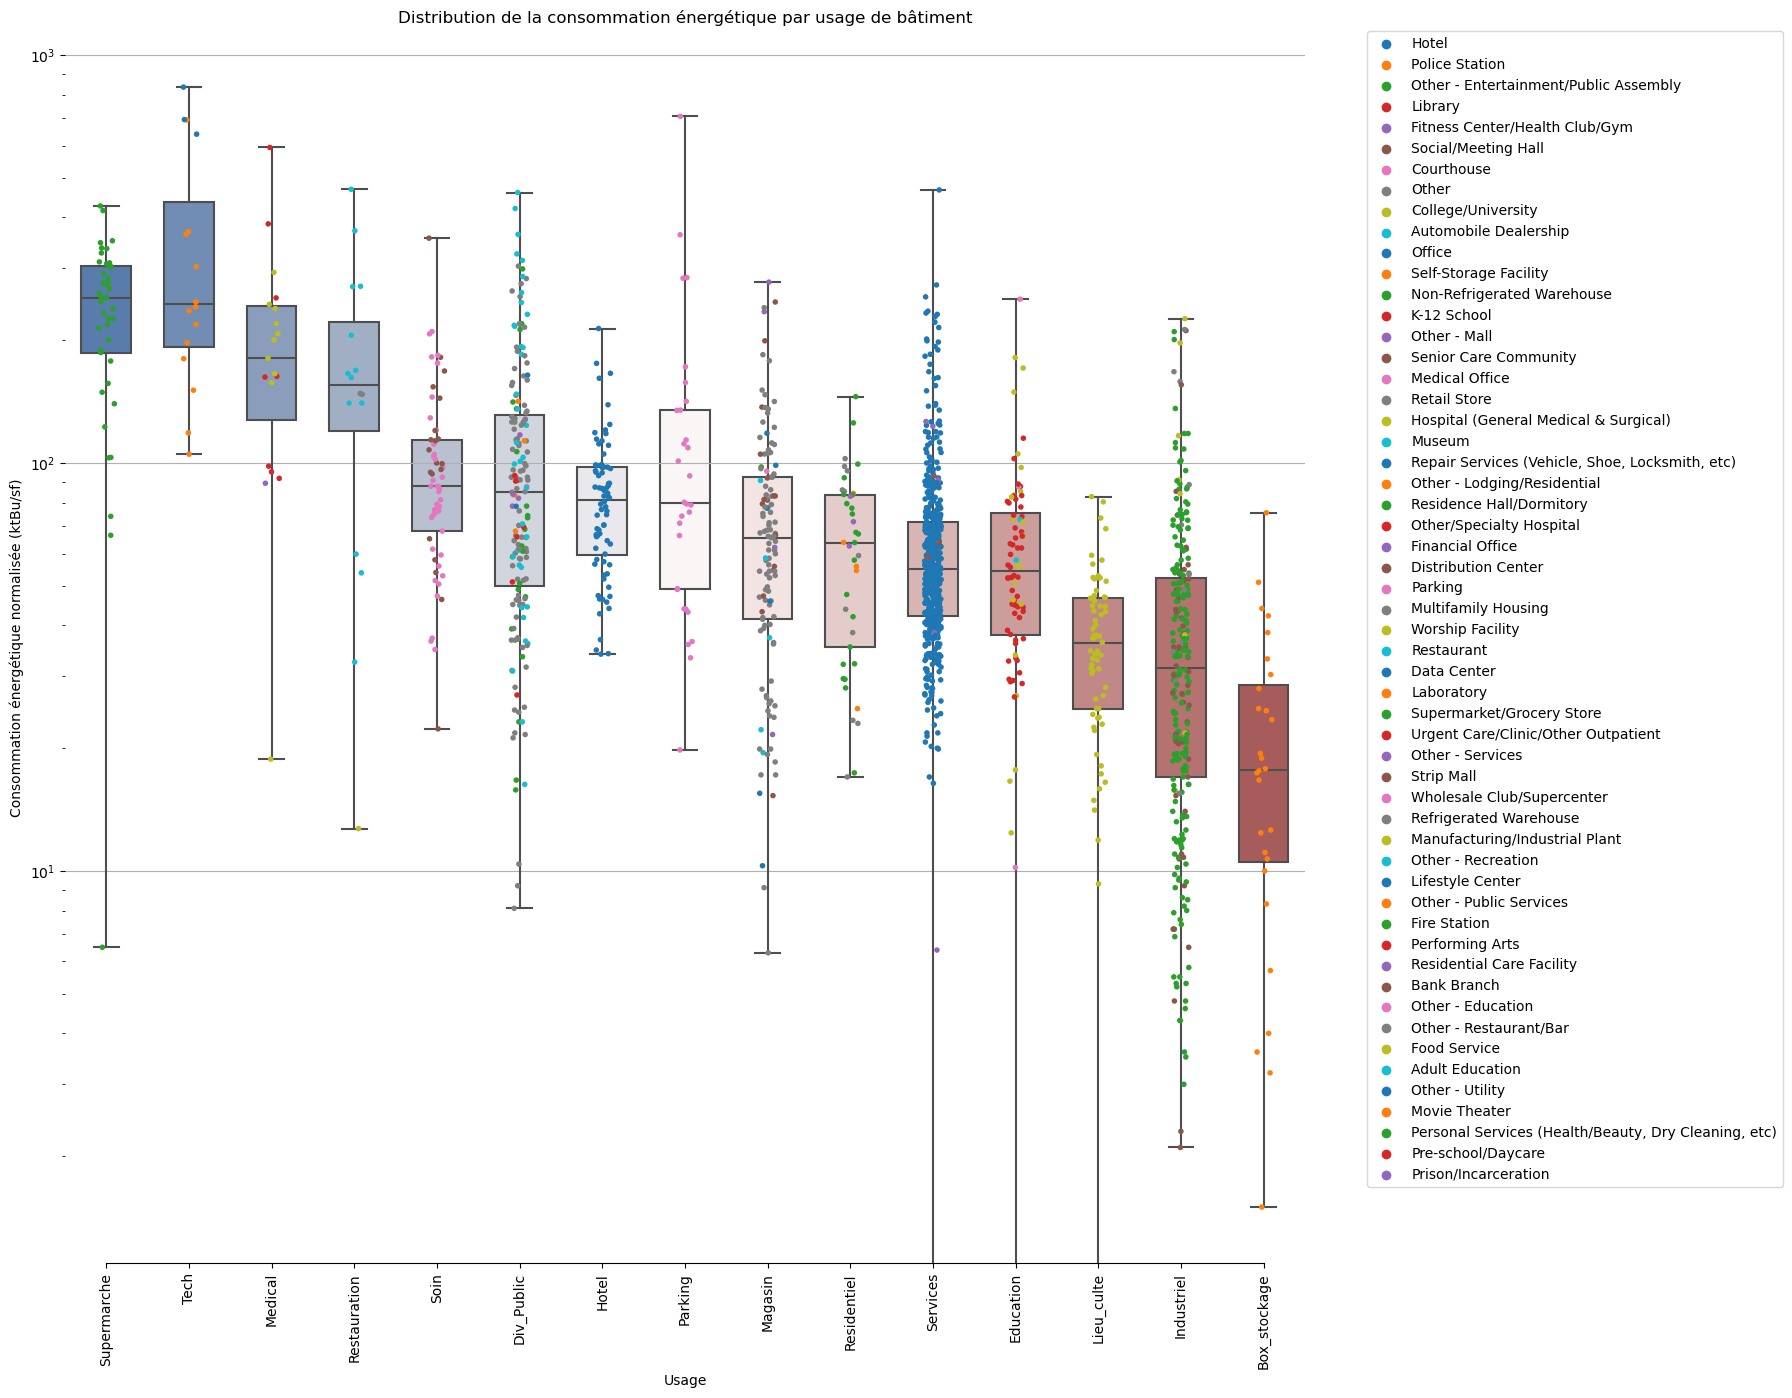

In [114]:
# Initialisation de la figure avec un axe y en échelle log
f, ax = plt.subplots(figsize=(16, 16))
ax.set_yscale("log")

# Boxplot + points
order = df.groupby('Categorie')['Conso_norm'].median().sort_values(ascending=False).index
sns.boxplot(x="Categorie", y="Conso_norm", data=df, whis=[0, 100], palette="vlag", width=.6, order=order)
sns.stripplot(x="Categorie", y="Conso_norm", data=df,size=4, hue='Usage_premier', linewidth=0, order=order, palette="tab10")

# Présentation visuelle
ax.yaxis.grid(True)
ax.set(ylabel="Consommation énergétique normalisée (ktBu/sf)", xlabel="Usage", title="Distribution de la consommation énergétique par usage de bâtiment")
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

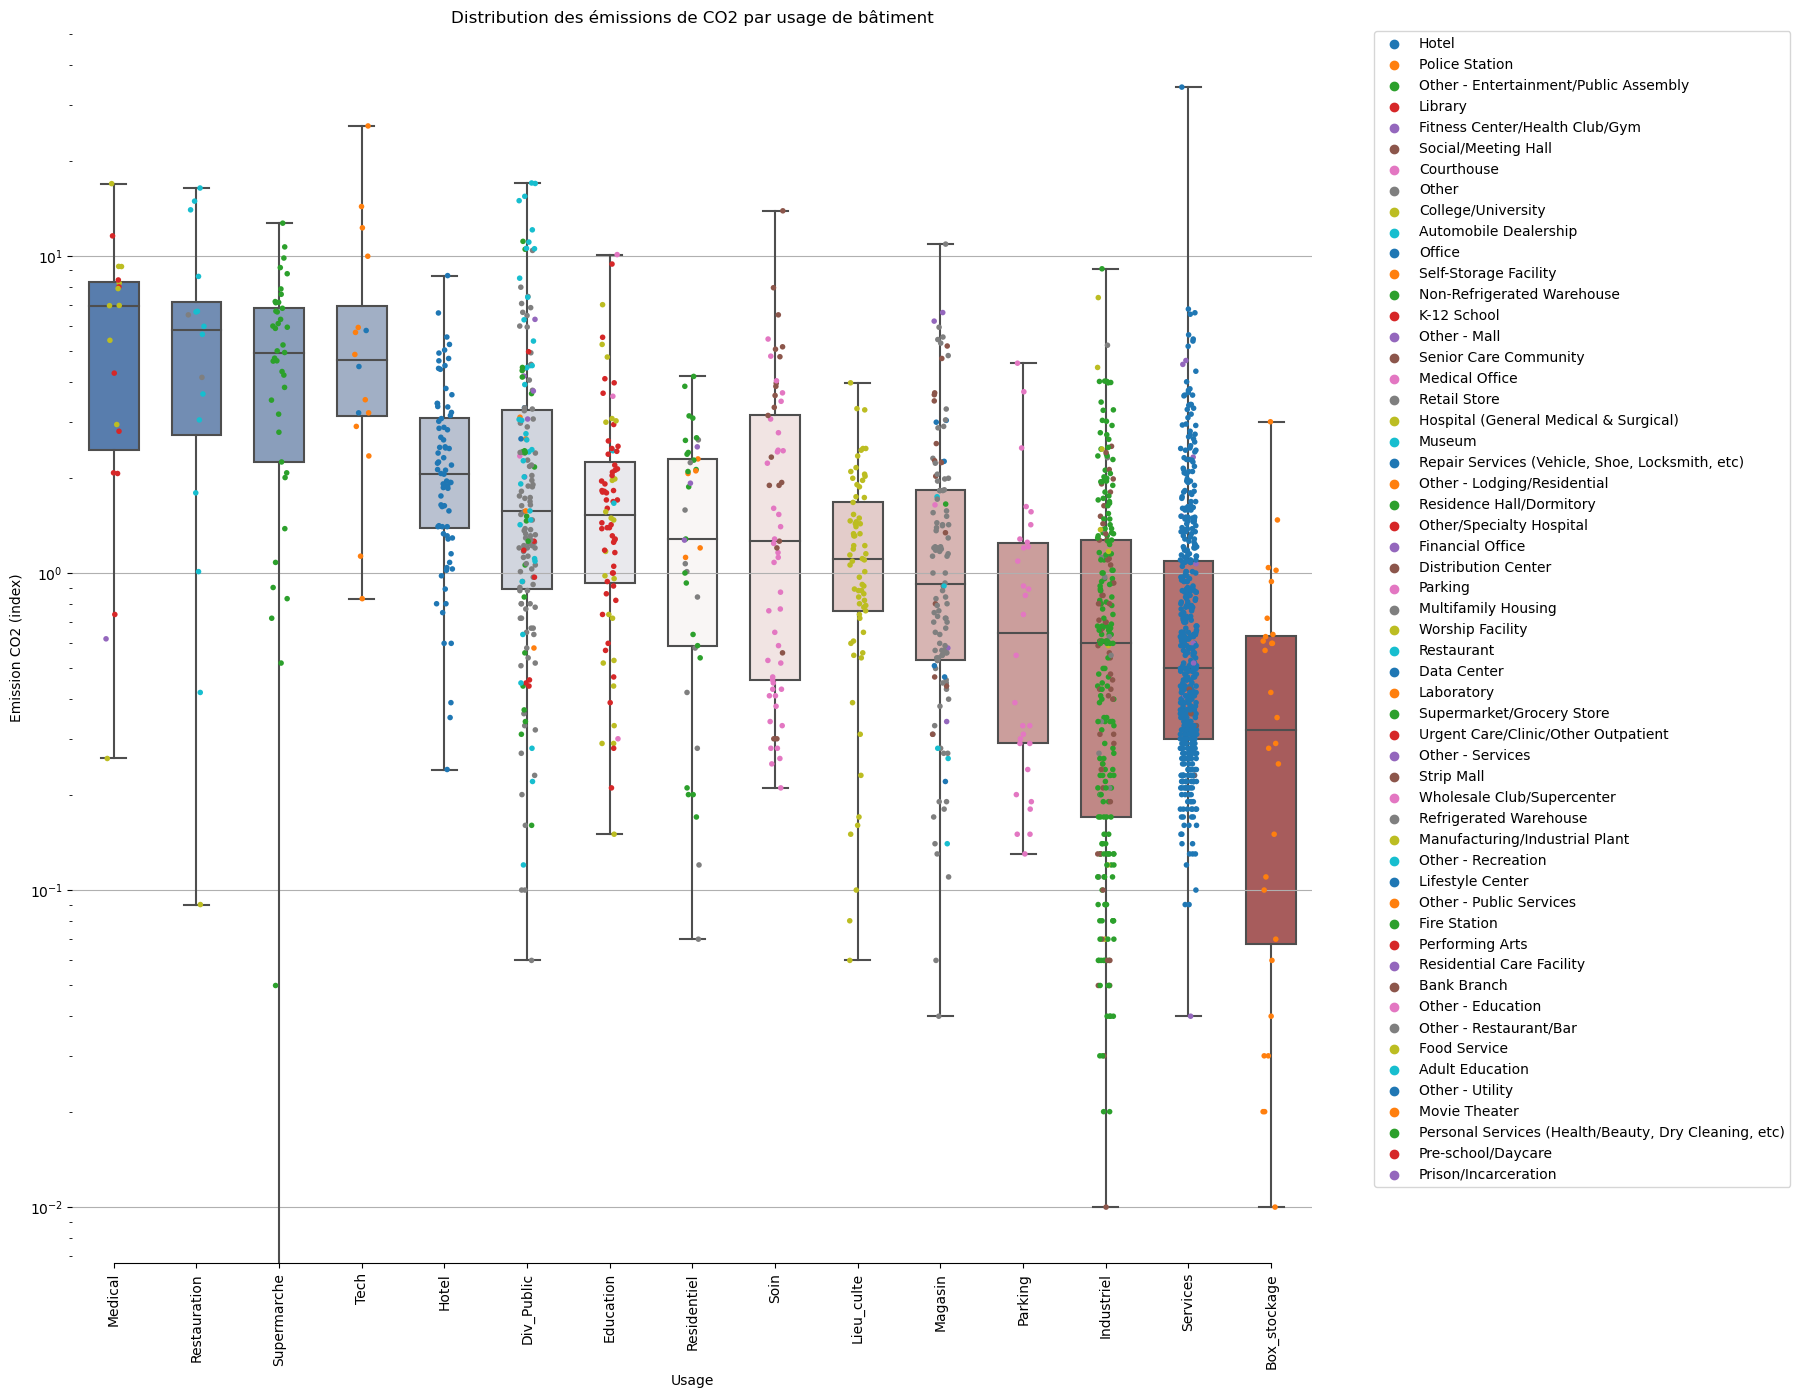

In [115]:
# Initialisation de la figure avec un axe y en échelle log
f, ax = plt.subplots(figsize=(16, 16))
ax.set_yscale("log")

# Boxplot + points
order = df.groupby('Categorie')['Emissions_index'].median().sort_values(ascending=False).index
sns.boxplot(x="Categorie", y="Emissions_index", data=df, whis=[0, 100], palette="vlag", width=.6, order=order)
sns.stripplot(x="Categorie", y="Emissions_index", data=df,size=4, hue='Usage_premier', linewidth=0, order=order, palette="tab10")

# Présentation visuelle
ax.yaxis.grid(True)
ax.set(ylabel="Emission CO2 (index)", xlabel="Usage", title="Distribution des émissions de CO2 par usage de bâtiment")
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

L'exercice de catégorisation des cas d'usages des bâtiments a été réalisé "humainement", de manière itérative, afin de trouver le meilleur compris entre :
- la logique des catégories, qui influencera notamment le caractère de généralisation du modèle.
- la réduction des variances intra-classes, afin de limiter la variance résiduelle du dataset.

In [116]:
df.to_csv('df_preprocess.csv')

In [117]:
df_resultats.to_csv('df_resultats.csv')

Le dataset ainsi créé est prêt à faire l'objet d'une modélisation avancée. 
- La modélisation de la consommation d'énergie sera développée dans le notebook#2
- La modélisation de les emissions de CO2 sera développée dans le notebook#3